# Импорты

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline

# Для более качественных графиков
%config InlineBackend.figure_format='retina'
plt.rcParams["figure.dpi"] = 150

# Датасет

In [3]:
# import mba

from src.mba import modeling, vis
from src.mba.const import DATA_PATH, TARGET

loan_data = pd.read_csv(DATA_PATH)
loan_data

лимит_нарушен  пол  тип  цель  кредитоспособность  другие_кредиты  \
0               0.0    м  3.0   0.0                 1.0             NaN   
1               0.0  NaN  NaN   0.0                 1.0             0.0   
2               0.0    м  3.0   1.0                 1.0             0.0   
3               0.0  NaN  3.0   1.0                 1.0             0.0   
4               0.0  NaN  3.0   1.0                 NaN             0.0   
...             ...  ...  ...   ...                 ...             ...   
7995            0.0  NaN  3.0   1.0                 NaN             0.0   
7996            NaN  NaN  NaN   1.0                 1.0             0.0   
7997            0.0    м  3.0   3.0                 1.0             NaN   
7998            NaN  NaN  NaN   1.0                 1.0             0.0   
7999            0.0    ж  1.0   0.0                 1.0             0.0   

      бизнес          сумма                    сбор        срок  ...  \
0        0.0  174765.264968                  normal  245.885949  ...   
1        0.0            NaN                    want  365.885949  ...   
2        0.0            NaN                 regular  365.885949  ...   
3        0.0  474765.264968                  common  365.885949  ...   
4        0.0  384765.264968               excessive  365.885949  ...   
...      ...            ...                     ...         ...  ...   
7995     0.0            NaN              not slight  125.885949  ...   
7996     1.0            NaN                    mean  185.885949  ...   
7997     0.0  394765.264968     Whole lotta nothin'  365.885949  ...   
7998     0.0  594765.264968  Total lack of presence  365.885949  ...   
7999     0.0  684765.264968               minuscule  365.885949  ...   

      один_платеж  стоимость_имущества  работа  тип_залога тип_кредита  \
0             0.0        244488.111841     осн         дом         2.0   
1             0.0                  NaN     осн         дом         1.0   
2             NaN        364488.111841     осн         дом         1.0   
3             0.0        894488.111841     осн         дом         NaN   
4             0.0        504488.111841     осн         дом         NaN   
...           ...                  ...     ...         ...         ...   
7995          0.0        744488.111841     осн         дом         2.0   
7996          0.0        184488.111841     осн         дом         1.0   
7997          0.0                  NaN     осн         дом         4.0   
7998          0.0                  NaN     осн         дом         NaN   
7999          0.0                  NaN     осн         дом         2.0   

     кредитный_рейтинг  возраст  прямой_залог дефолт  \
0           709.508335    55-64           1.0      0   
1           722.508335    55-64           NaN      0   
2           785.508335    55-64           1.0      0   
3           594.508335    35-44           1.0      0   
4           589.508335    55-64           NaN      0   
...                ...      ...           ...    ...   
7995               NaN    35-44           NaN      0   
7996        796.508335      >74           1.0      0   
7997        584.508335    25-34           1.0      1   
7998        873.508335    35-44           1.0      0   
7999               NaN    35-44           1.0      0   

                                                   речь  
0     "Hey there! I’m a guy with a solid job and a m...  
1     "Hi there! We are a couple with a solid financ...  
2     "I'm a male client with a modest income. I wor...  
3     "Hello, we’re a working couple enjoying the st...  
4     "Greetings, we're Chris and Sam. Both employed...  
...                                                 ...  
7995  "Hello! I’m here to introduce myself. I have a...  
7996  "Hello! I’m excited to be here. My income is m...  
7997  "I'm just an ordinary guy trying to make ends ...  
7998  "Hello! We’re a couple looking to manage our f...  
7999  "I'm a successful businesswoman wi

### Бизнес: какова задача

Имеем список клиентов банка и разметку того, расплатились ли они за кредит. Банк всегда выдает кредит со ставкой 10% годовых. Бизнес-задача: суметь предсказывать дефолт клиента, чтобы отказывать таким клиентам/повышать ставку для них

### Датасет: какие есть признаки

### Модель: бейзлайн (константное значение)

In [4]:
def baseline(data: pd.DataFrame) -> None:
    _, y = modeling.get_xy(data)
    pred = y.mode()[0]
    acc = (y == pred).mean()
    print(f"Accuracy: {acc:.3f}")


baseline(loan_data)

Accuracy: 0.763


### Модель: без исследования

При таком решении я могу построить лог рег/бустинг и посчитать точность/f1 на всем датасете

Стоит ли им здесь предложить бустинг? 

In [ ]:
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression


def train_log_reg(data: pd.DataFrame) -> None:
    X, y = modeling.get_xy(data)
    num_cols = X.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", modeling.ManualFeatureSelector(num_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    modeling.print_metrics(y_true=y, y_pred=pred)


def train_catboost(data: pd.DataFrame) -> None:
    X, y = modeling.get_xy(data)
    cat_cols = list(X.select_dtypes(object).columns)

    model = CatBoostClassifier(cat_features=cat_cols, random_state=42, allow_writing_files=False, verbose=False)
    pipe = Pipeline(
        [
            ("cat_to_str", modeling.ObjectToStringTransformer()),
            ("model", model),
        ]
    )

    pipe.fit(X, y)
    pred = pipe.predict(X)
    modeling.print_metrics(y_true=y, y_pred=pred)

### Датасет: какие есть признаки, какие у них значения

Тут можно быть более интерактивным? Каждую фичу можно потыкать по указанию

In [7]:
loan_data.iloc[:, :12]

лимит_нарушен  пол  тип  цель  кредитоспособность  другие_кредиты  \
0               0.0    м  3.0   0.0                 1.0             NaN   
1               0.0  NaN  NaN   0.0                 1.0             0.0   
2               0.0    м  3.0   1.0                 1.0             0.0   
3               0.0  NaN  3.0   1.0                 1.0             0.0   
4               0.0  NaN  3.0   1.0                 NaN             0.0   
...             ...  ...  ...   ...                 ...             ...   
7995            0.0  NaN  3.0   1.0                 NaN             0.0   
7996            NaN  NaN  NaN   1.0                 1.0             0.0   
7997            0.0    м  3.0   3.0                 1.0             NaN   
7998            NaN  NaN  NaN   1.0                 1.0             0.0   
7999            0.0    ж  1.0   0.0                 1.0             0.0   

      бизнес          сумма                    сбор        срок  амортизация  \
0        0.0  174765.264968                  normal  245.885949          0.0   
1        0.0            NaN                    want  365.885949          0.0   
2        0.0            NaN                 regular  365.885949          0.0   
3        0.0  474765.264968                  common  365.885949          0.0   
4        0.0  384765.264968               excessive  365.885949          0.0   
...      ...            ...                     ...         ...          ...   
7995     0.0            NaN              not slight  125.885949          0.0   
7996     1.0            NaN                    mean  185.885949          0.0   
7997     0.0  394765.264968     Whole lotta nothin'  365.885949          0.0   
7998     0.0  594765.264968  Total lack of presence  365.885949          0.0   
7999     0.0  684765.264968               minuscule  365.885949          0.0   

      только_процент  
0                0.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  
...              ...  
7995             0.0  
7996             1.0  
7997             0.0  
7998             0.0  
7999             0.0  

[8000 rows x 12 columns]

In [8]:
loan_data.iloc[:, 12:]

один_платеж  стоимость_имущества работа тип_залога  тип_кредита  \
0             0.0        244488.111841    осн        дом          2.0   
1             0.0                  NaN    осн        дом          1.0   
2             NaN        364488.111841    осн        дом          1.0   
3             0.0        894488.111841    осн        дом          NaN   
4             0.0        504488.111841    осн        дом          NaN   
...           ...                  ...    ...        ...          ...   
7995          0.0        744488.111841    осн        дом          2.0   
7996          0.0        184488.111841    осн        дом          1.0   
7997          0.0                  NaN    осн        дом          4.0   
7998          0.0                  NaN    осн        дом          NaN   
7999          0.0                  NaN    осн        дом          2.0   

      кредитный_рейтинг возраст  прямой_залог  дефолт  \
0            709.508335   55-64           1.0       0   
1            722.508335   55-64           NaN       0   
2            785.508335   55-64           1.0       0   
3            594.508335   35-44           1.0       0   
4            589.508335   55-64           NaN       0   
...                 ...     ...           ...     ...   
7995                NaN   35-44           NaN       0   
7996         796.508335     >74           1.0       0   
7997         584.508335   25-34           1.0       1   
7998         873.508335   35-44           1.0       0   
7999                NaN   35-44           1.0       0   

                                                   речь  
0     "Hey there! I’m a guy with a solid job and a m...  
1     "Hi there! We are a couple with a solid financ...  
2     "I'm a male client with a modest income. I wor...  
3     "Hello, we’re a working couple enjoying the st...  
4     "Greetings, we're Chris and Sam. Both employed...  
...                                                 ...  
7995  "Hello! I’m here to introduce myself. I have a...  
7996  "Hello! I’m excited to be here. My income is m...  
7997  "I'm just an ordinary guy trying to make ends ...  
7998  "Hello! We’re a couple looking to manage our f...  
7999  "I'm a successful businesswoman with a dedicat...  

[8000 rows x 10 columns]

In [9]:
loan_data.describe()

лимит_нарушен          тип         цель  кредитоспособность  \
count    6462.000000  6466.000000  6442.000000          6406.00000   
mean        0.065305     2.664089     1.118131             0.96113   
std         0.247082     0.653671     1.138390             0.19330   
min         0.000000     1.000000     0.000000             0.00000   
25%         0.000000     3.000000     0.000000             1.00000   
50%         0.000000     3.000000     1.000000             1.00000   
75%         0.000000     3.000000     2.000000             1.00000   
max         1.000000     3.000000     3.000000             1.00000   

       другие_кредиты       бизнес         сумма         срок  амортизация  \
count     6425.000000  6369.000000  6.414000e+03  6376.000000  6338.000000   
mean         0.004669     0.134715  3.484416e+05   340.620736     0.101925   
std          0.068178     0.341446  1.842944e+05    59.079085     0.302573   
min          0.000000     0.000000  4.476526e+04   101.885949     0.000000   
25%          0.000000     0.000000  2.147653e+05   365.885949     0.000000   
50%          0.000000     0.000000  3.147653e+05   365.885949     0.000000   
75%          0.000000     0.000000  4.522653e+05   365.885949     0.000000   
max          1.000000     1.000000  3.024765e+06   365.885949     1.000000   

       только_процент  один_платеж  стоимость_имущества  тип_кредита  \
count     6435.000000  6396.000000         5.790000e+03  6340.000000   
mean         0.050971     0.019856         5.386556e+05     2.148580   
std          0.219956     0.139517         3.607842e+05     0.986423   
min          0.000000     0.000000         7.448811e+04     1.000000   
25%          0.000000     0.000000         3.144881e+05     1.000000   
50%          0.000000     0.000000         4.544881e+05     2.000000   
75%          0.000000     0.000000         6.644881e+05     3.000000   
max          1.000000     1.000000         4.914488e+06     4.000000   

       кредитный_рейтинг  прямой_залог       дефолт  
count        6386.000000   6420.000000  8000.000000  
mean          710.309933      0.999844     0.236750  
std           115.213366      0.012481     0.425114  
min           511.508335      0.000000     0.000000  
25%           611.508335      1.000000     0.000000  
50%           708.508335      1.000000     0.000000  
75%           810.508335      1.000000     0.000000  
max           911.508335      1.000000     1.000000

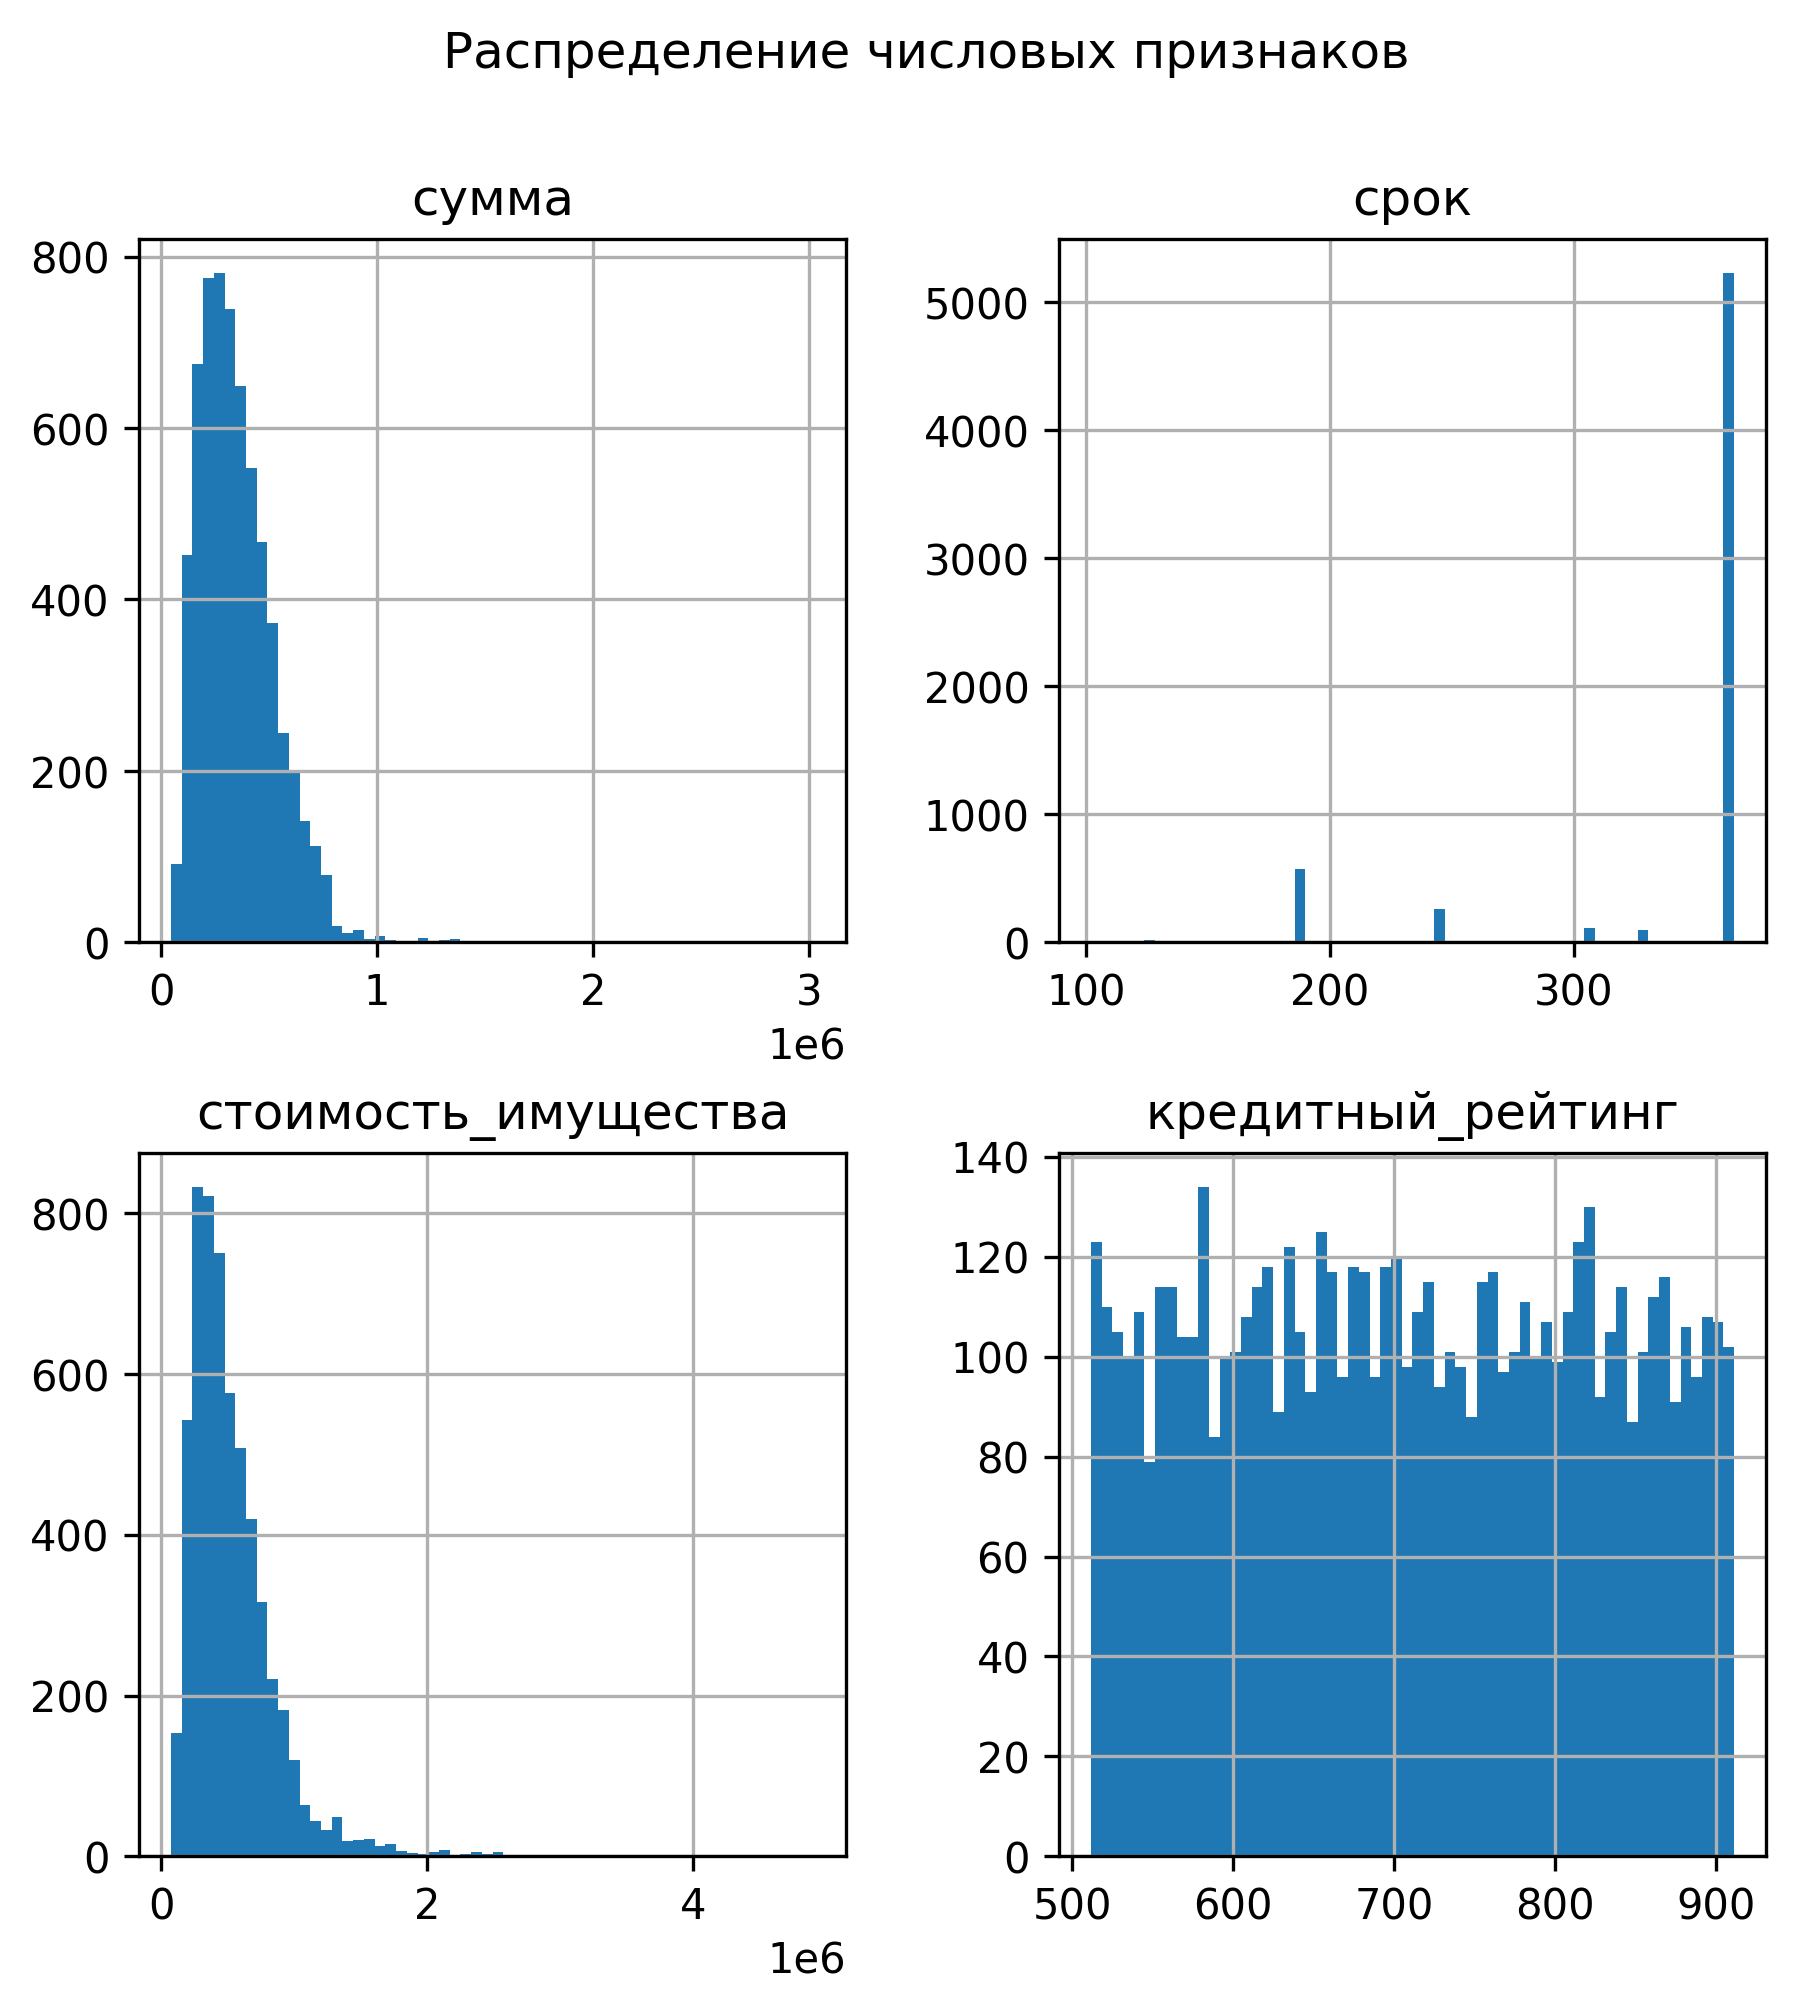

In [8]:
vis.plot_hist(loan_data)

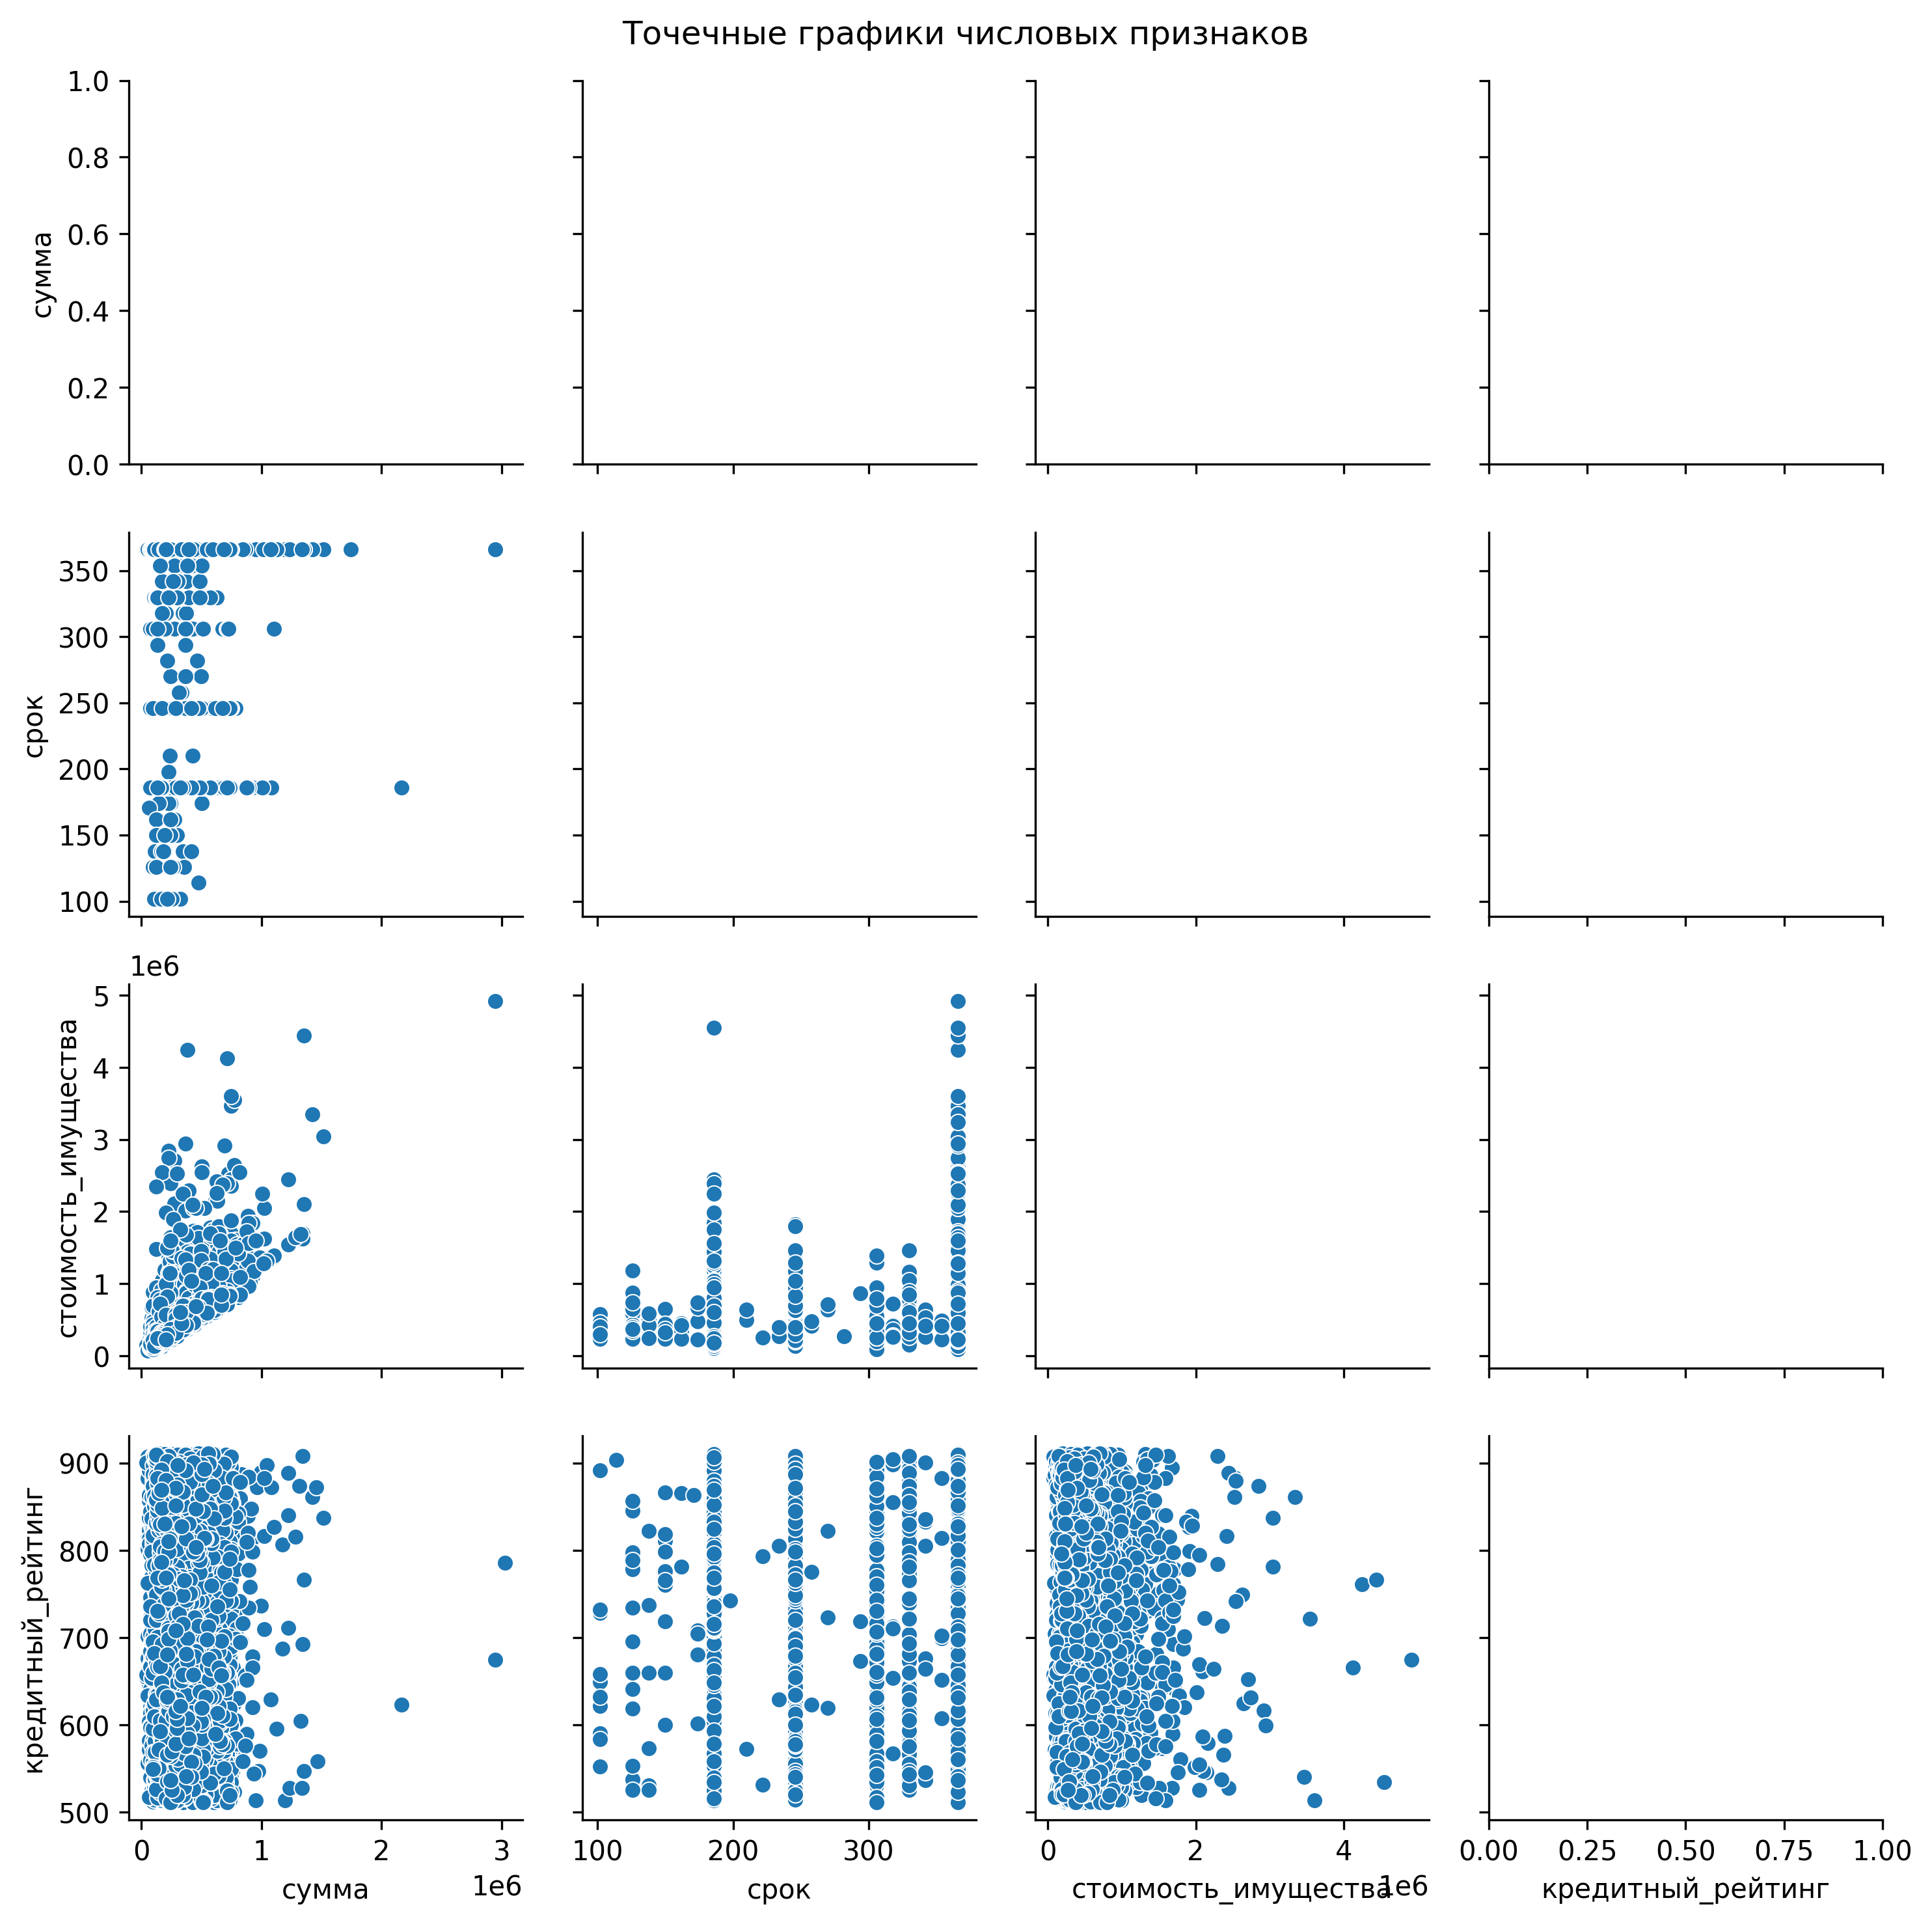

In [9]:
vis.plot_scatter(loan_data)

In [10]:
vis.print_value_counts(loan_data)

другие_кредиты
0.0    6395
1.0      30
Name: count, dtype: int64

сбор
routine                109
common                 102
Nothing to be found     92
middle                  90
popular                 89
                      ... 
not copious              1
not wide                 1
half-pint                1
not incalculable         1
slight                   1
Name: count, Length: 410, dtype: int64

работа
осн       7455
инвест     375
втор       170
Name: count, dtype: int64

лимит_нарушен
0.0    6040
1.0     422
Name: count, dtype: int64

бизнес
0.0    5511
1.0     858
Name: count, dtype: int64

прямой_залог
1.0    6419
0.0       1
Name: count, dtype: int64

цель
1.0    2472
0.0    2349
3.0    1489
2.0     132
Name: count, dtype: int64

амортизация
0.0    5692
1.0     646
Name: count, dtype: int64

один_платеж
0.0    6269
1.0     127
Name: count, dtype: int64

только_процент
0.0    6107
1.0     328
Name: count, dtype: int64

пол
м    2327
ж    1451
Name: count, dtype: int64

тип

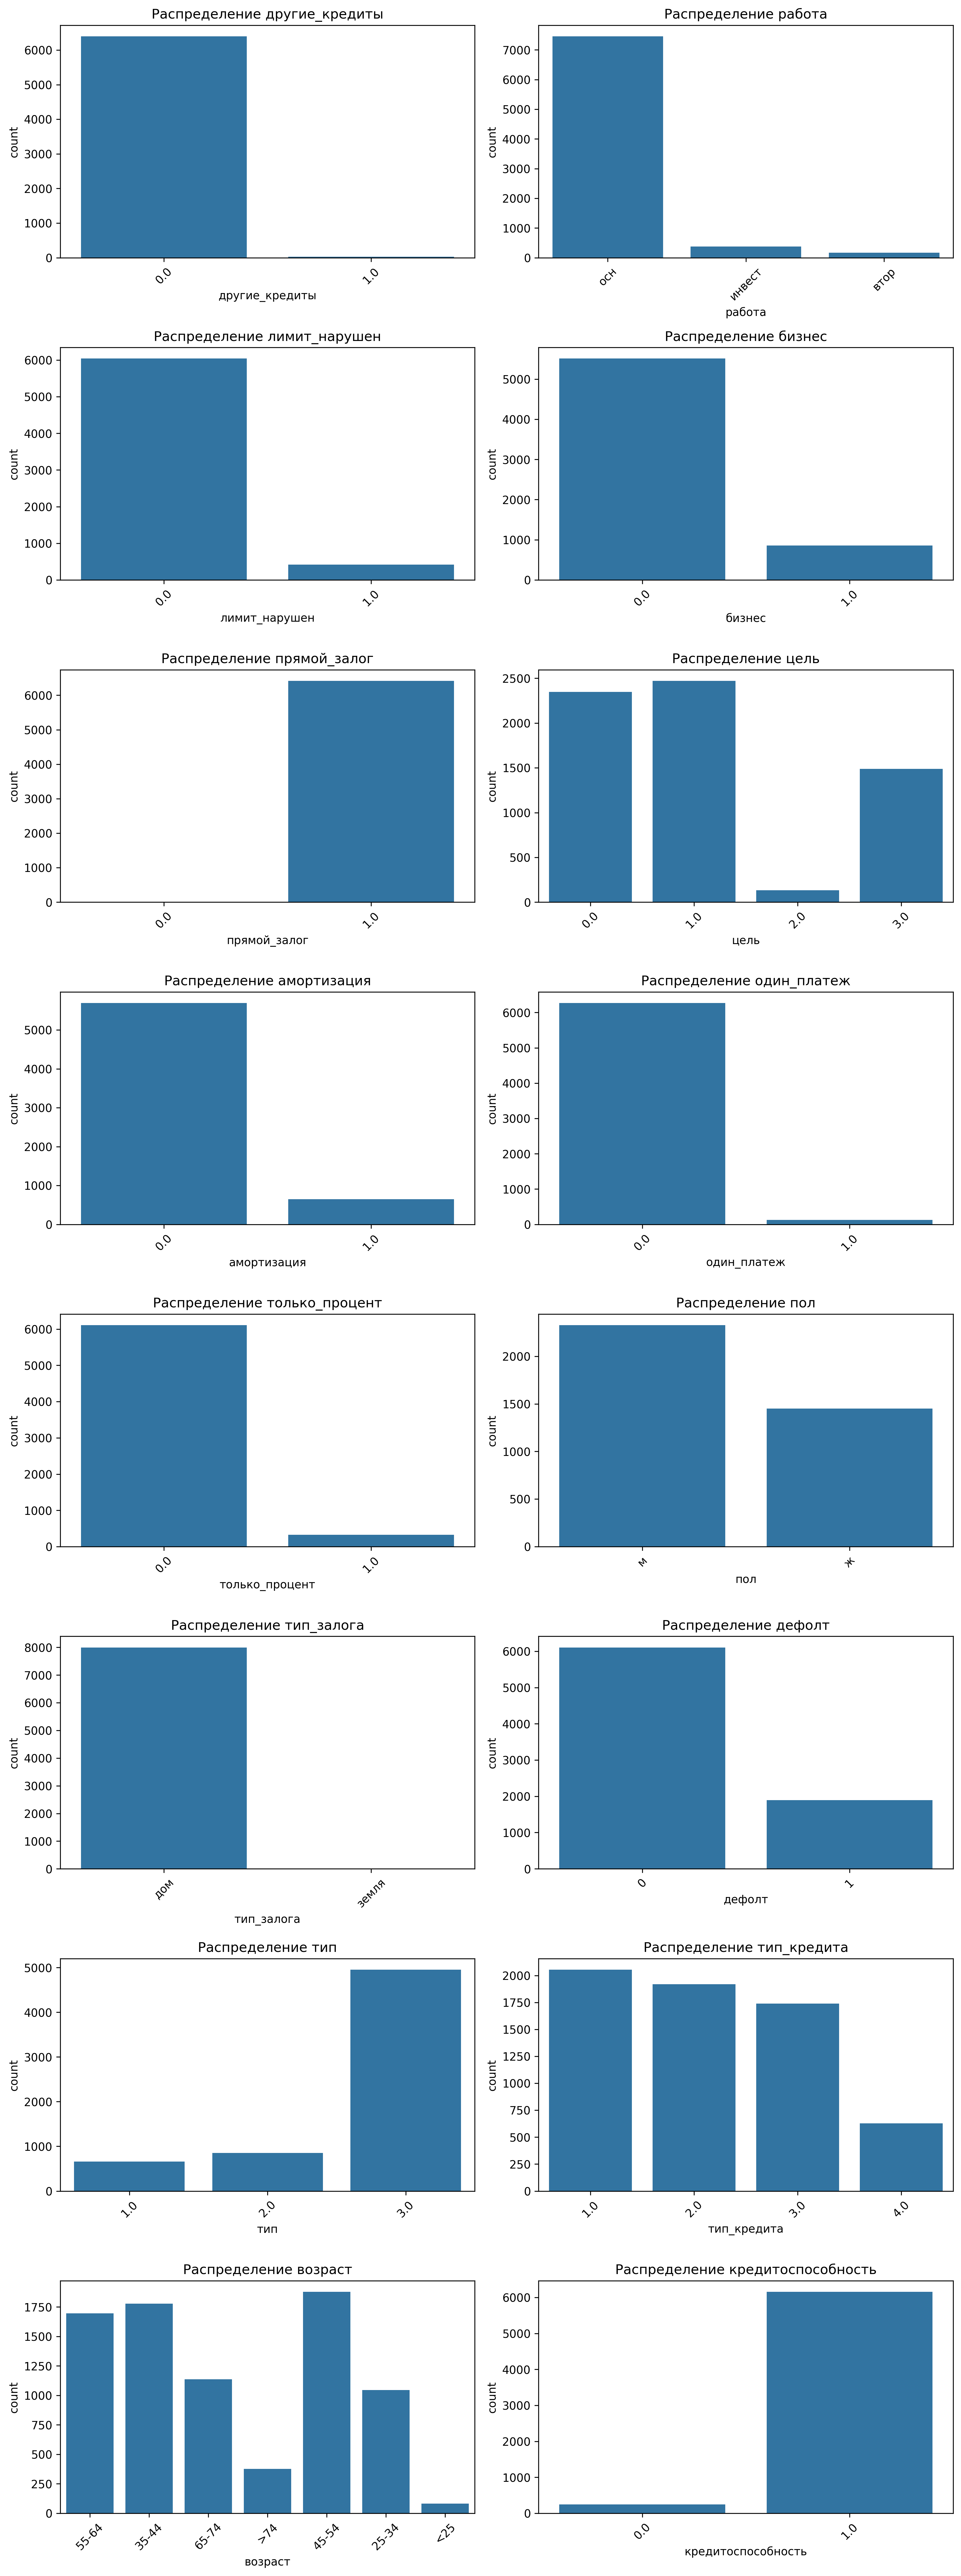

In [11]:
vis.plot_categorical_distributions(loan_data)

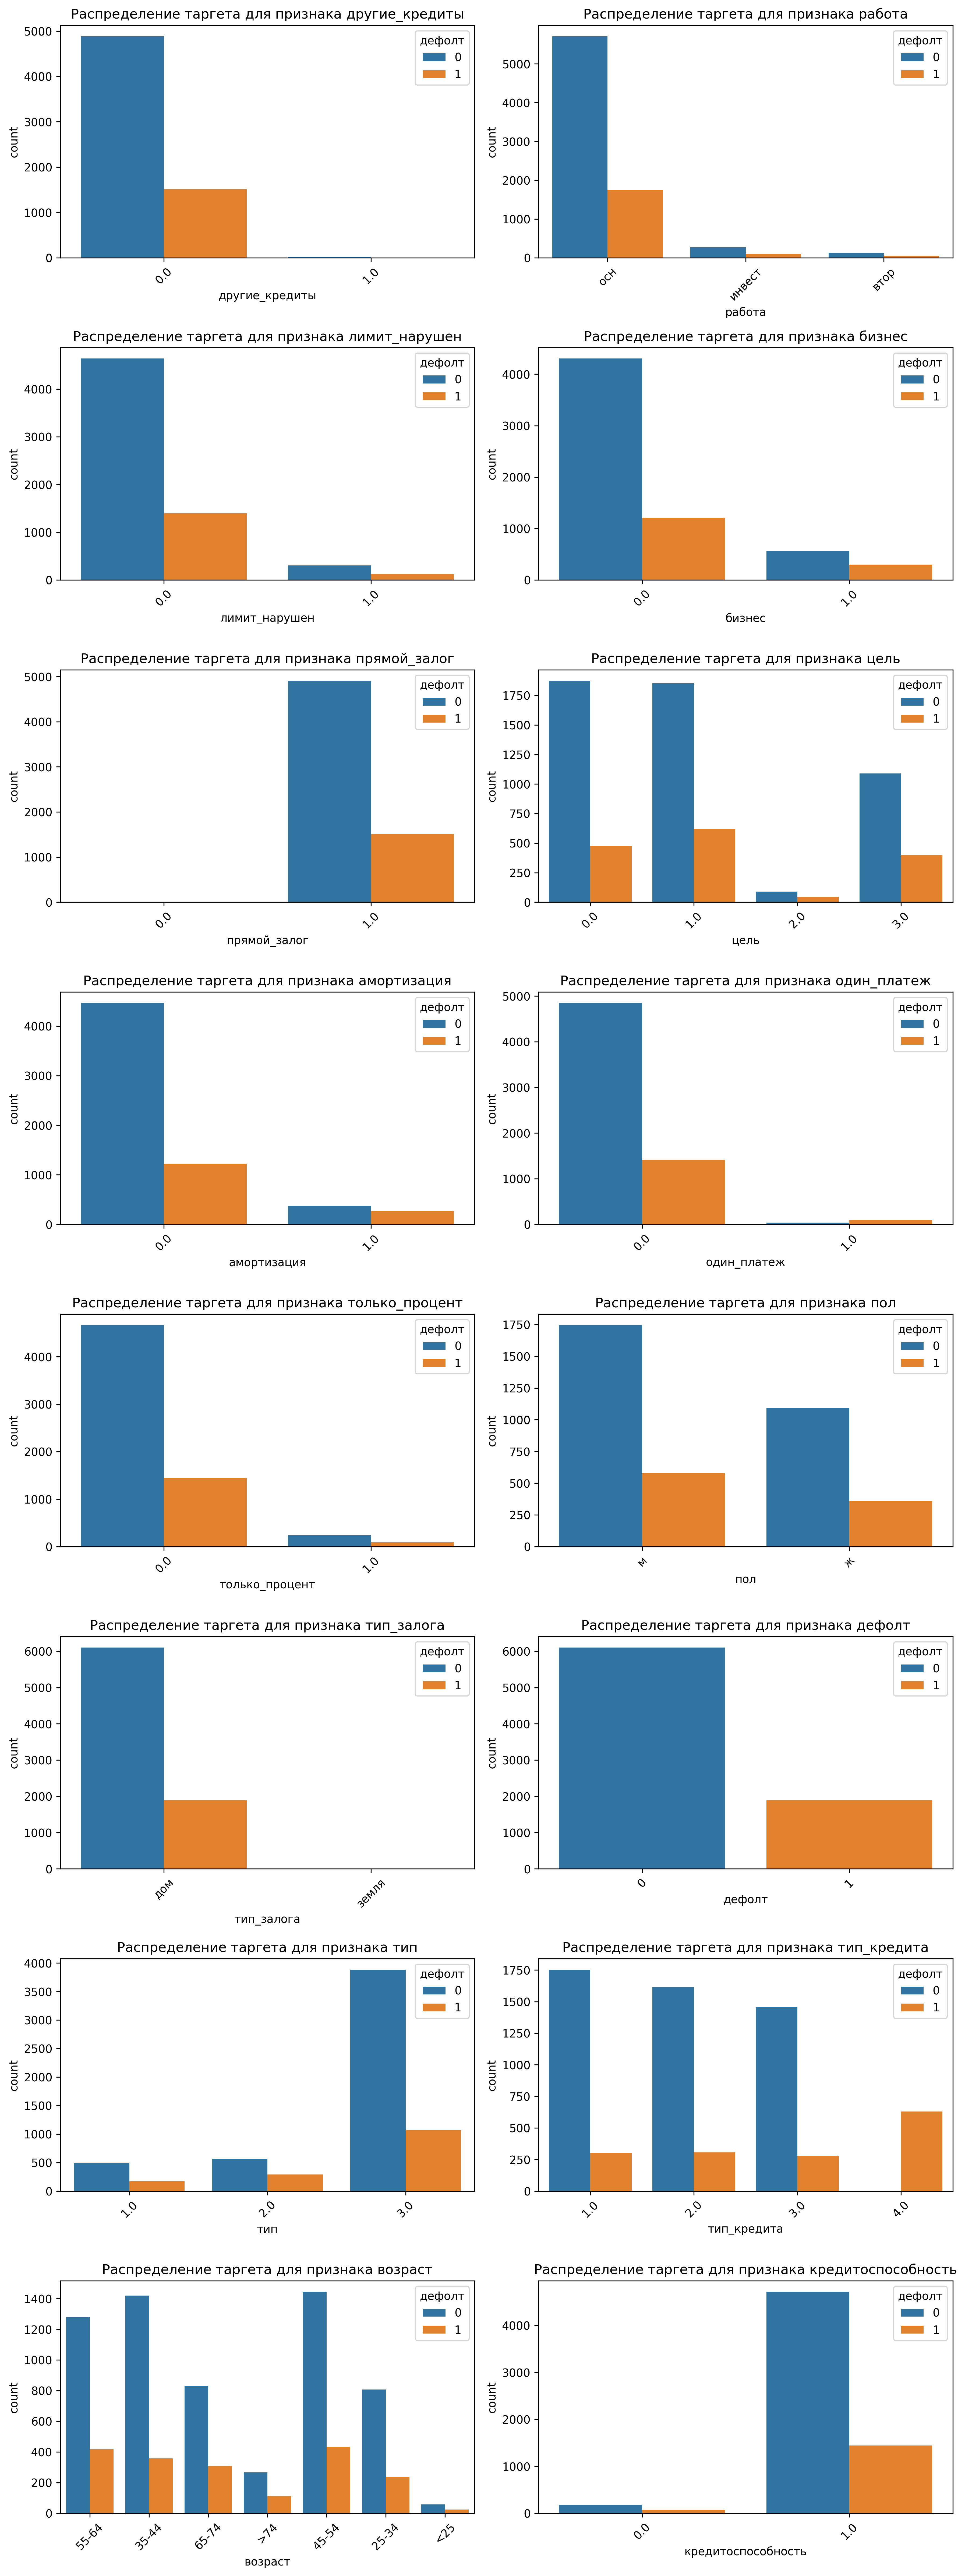

In [12]:
vis.visualize_cat_and_target(loan_data)

### Датасет: пропущенные значения

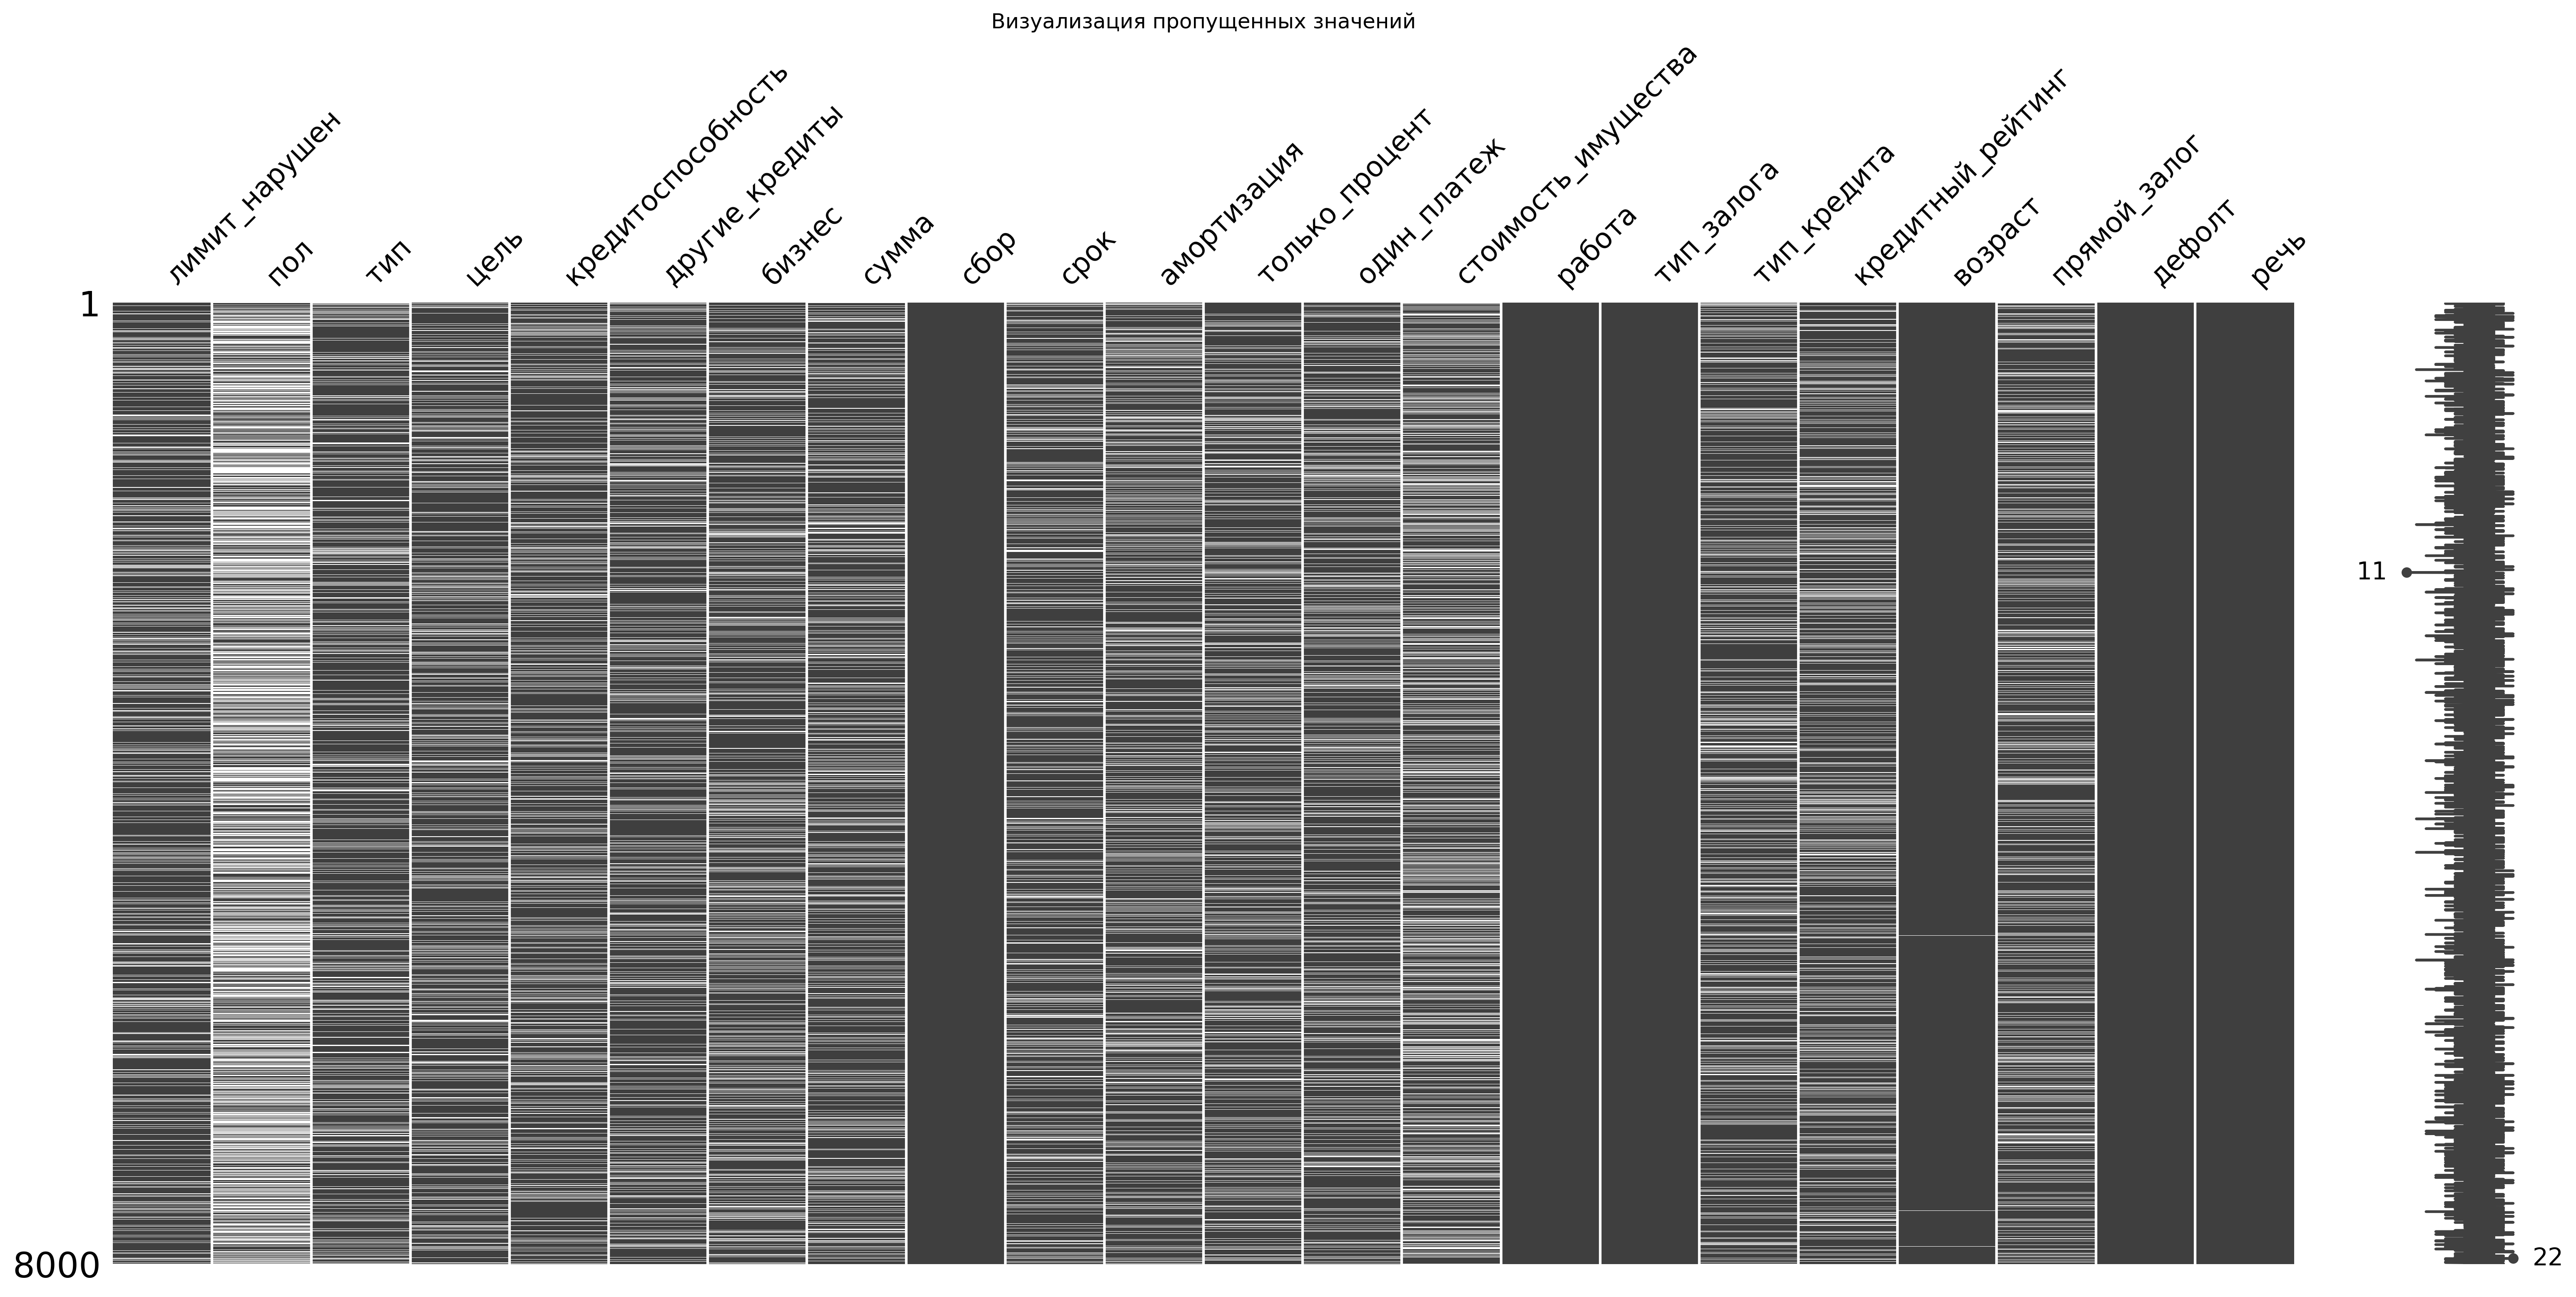

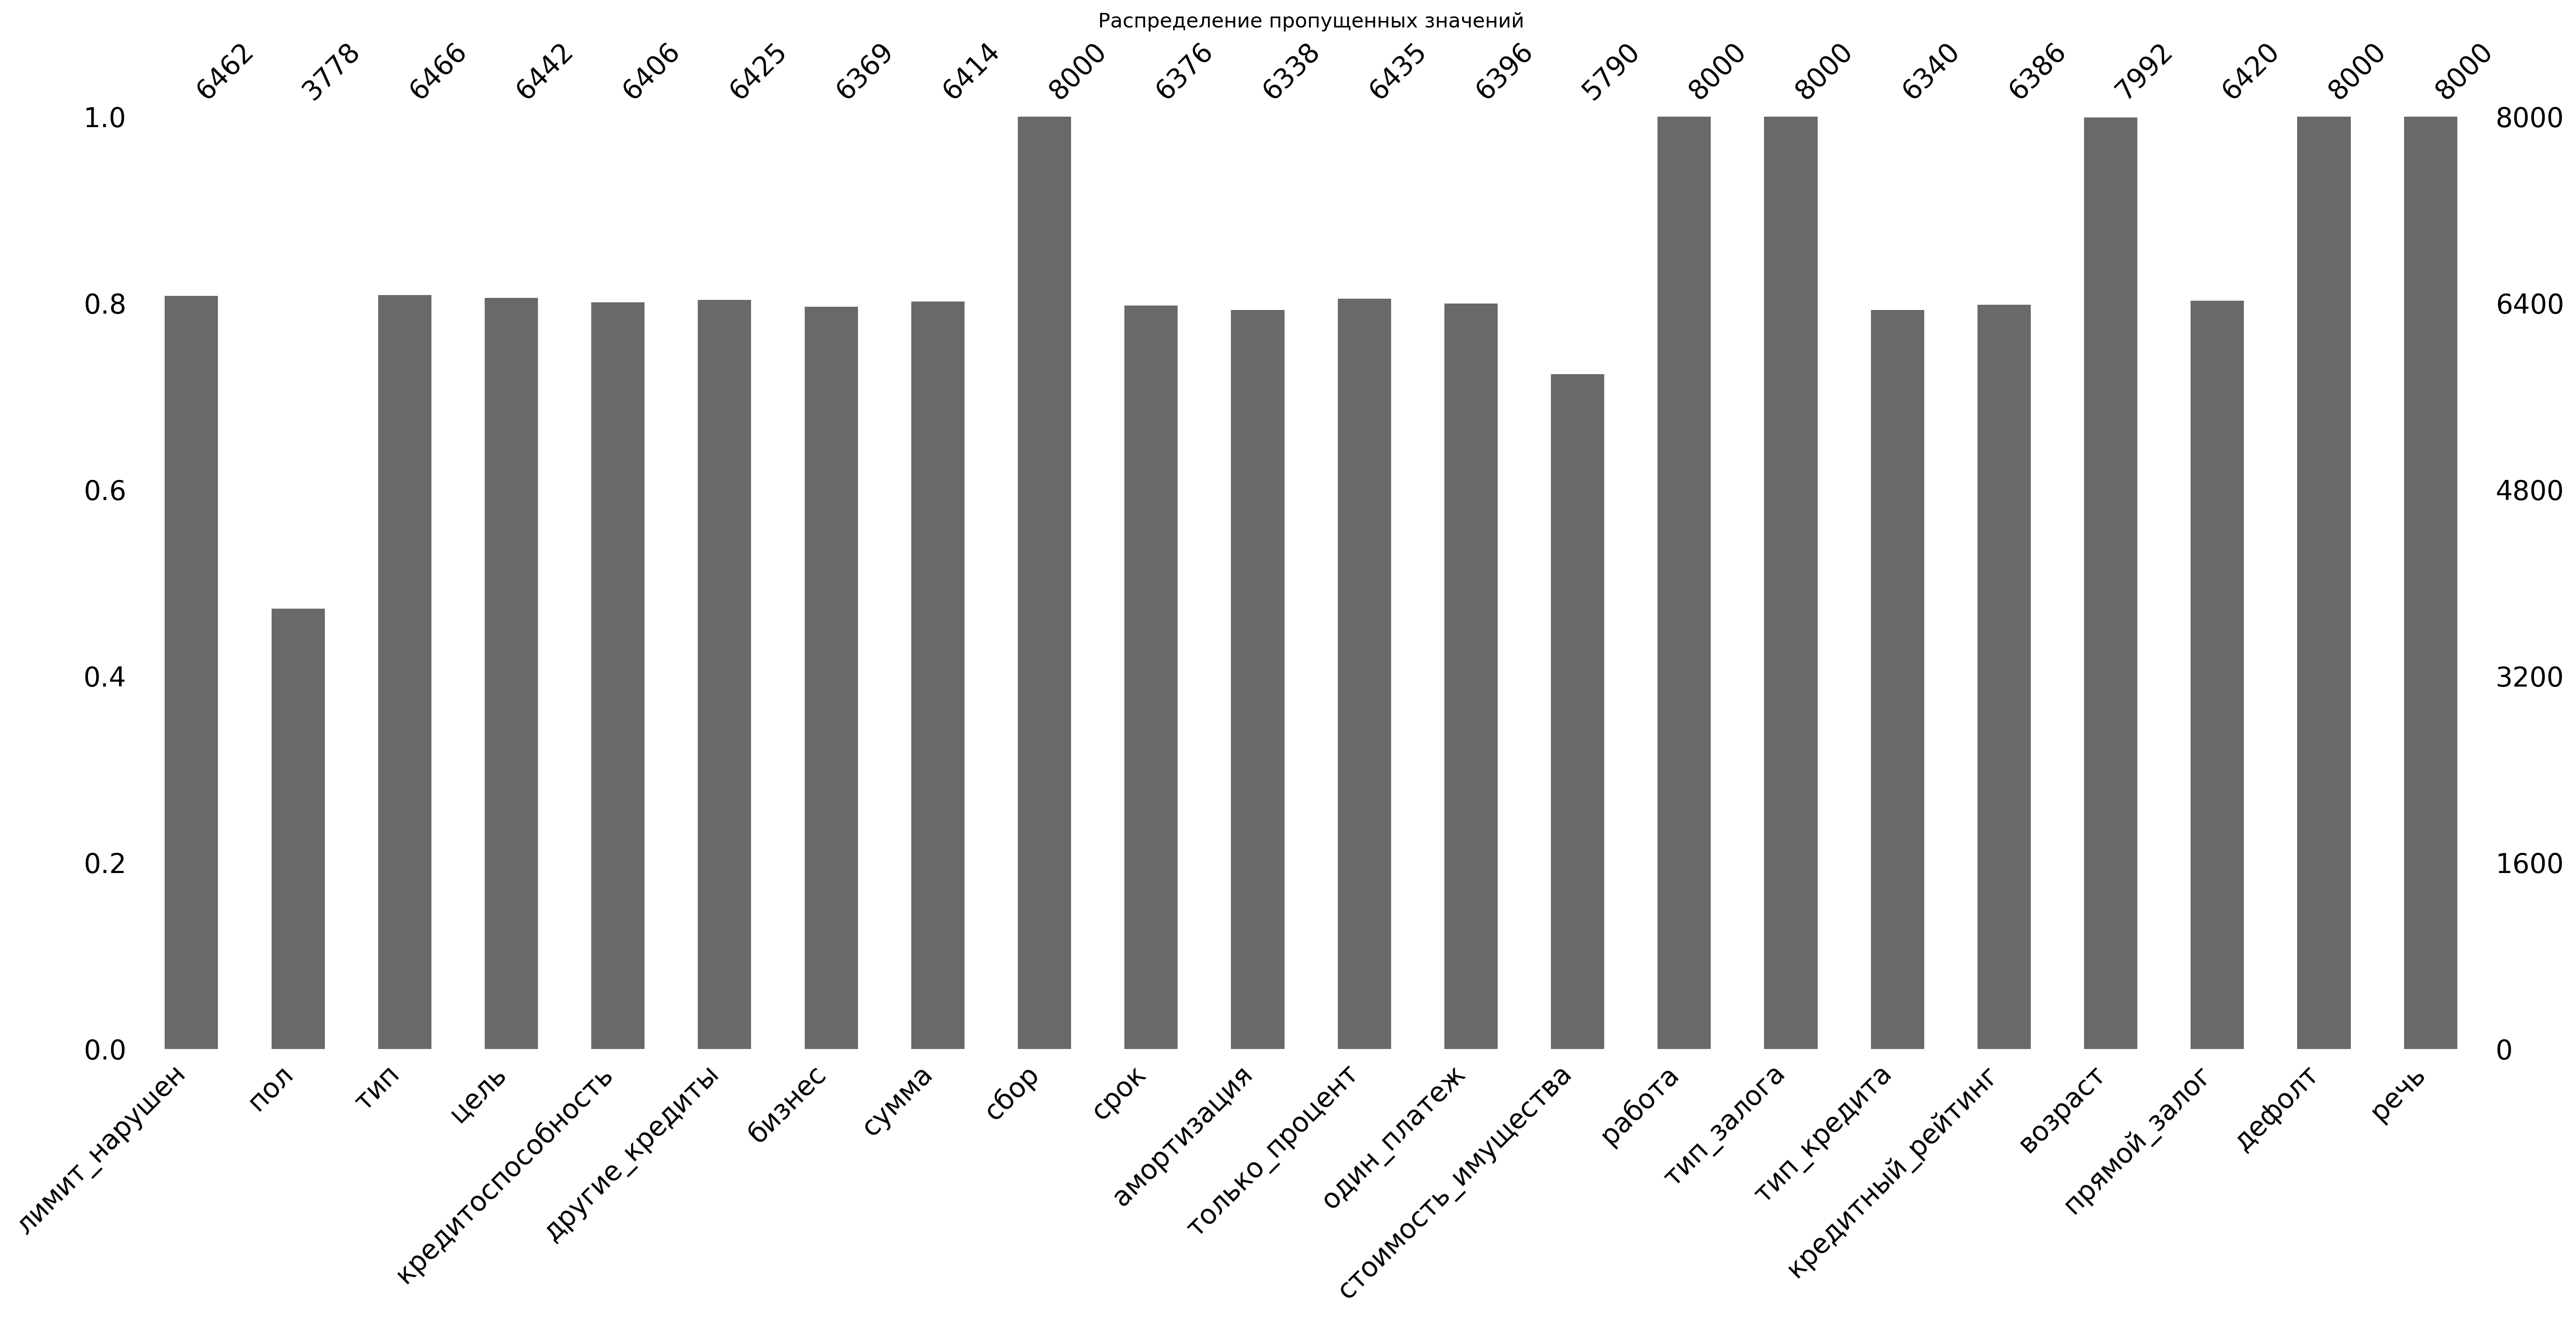

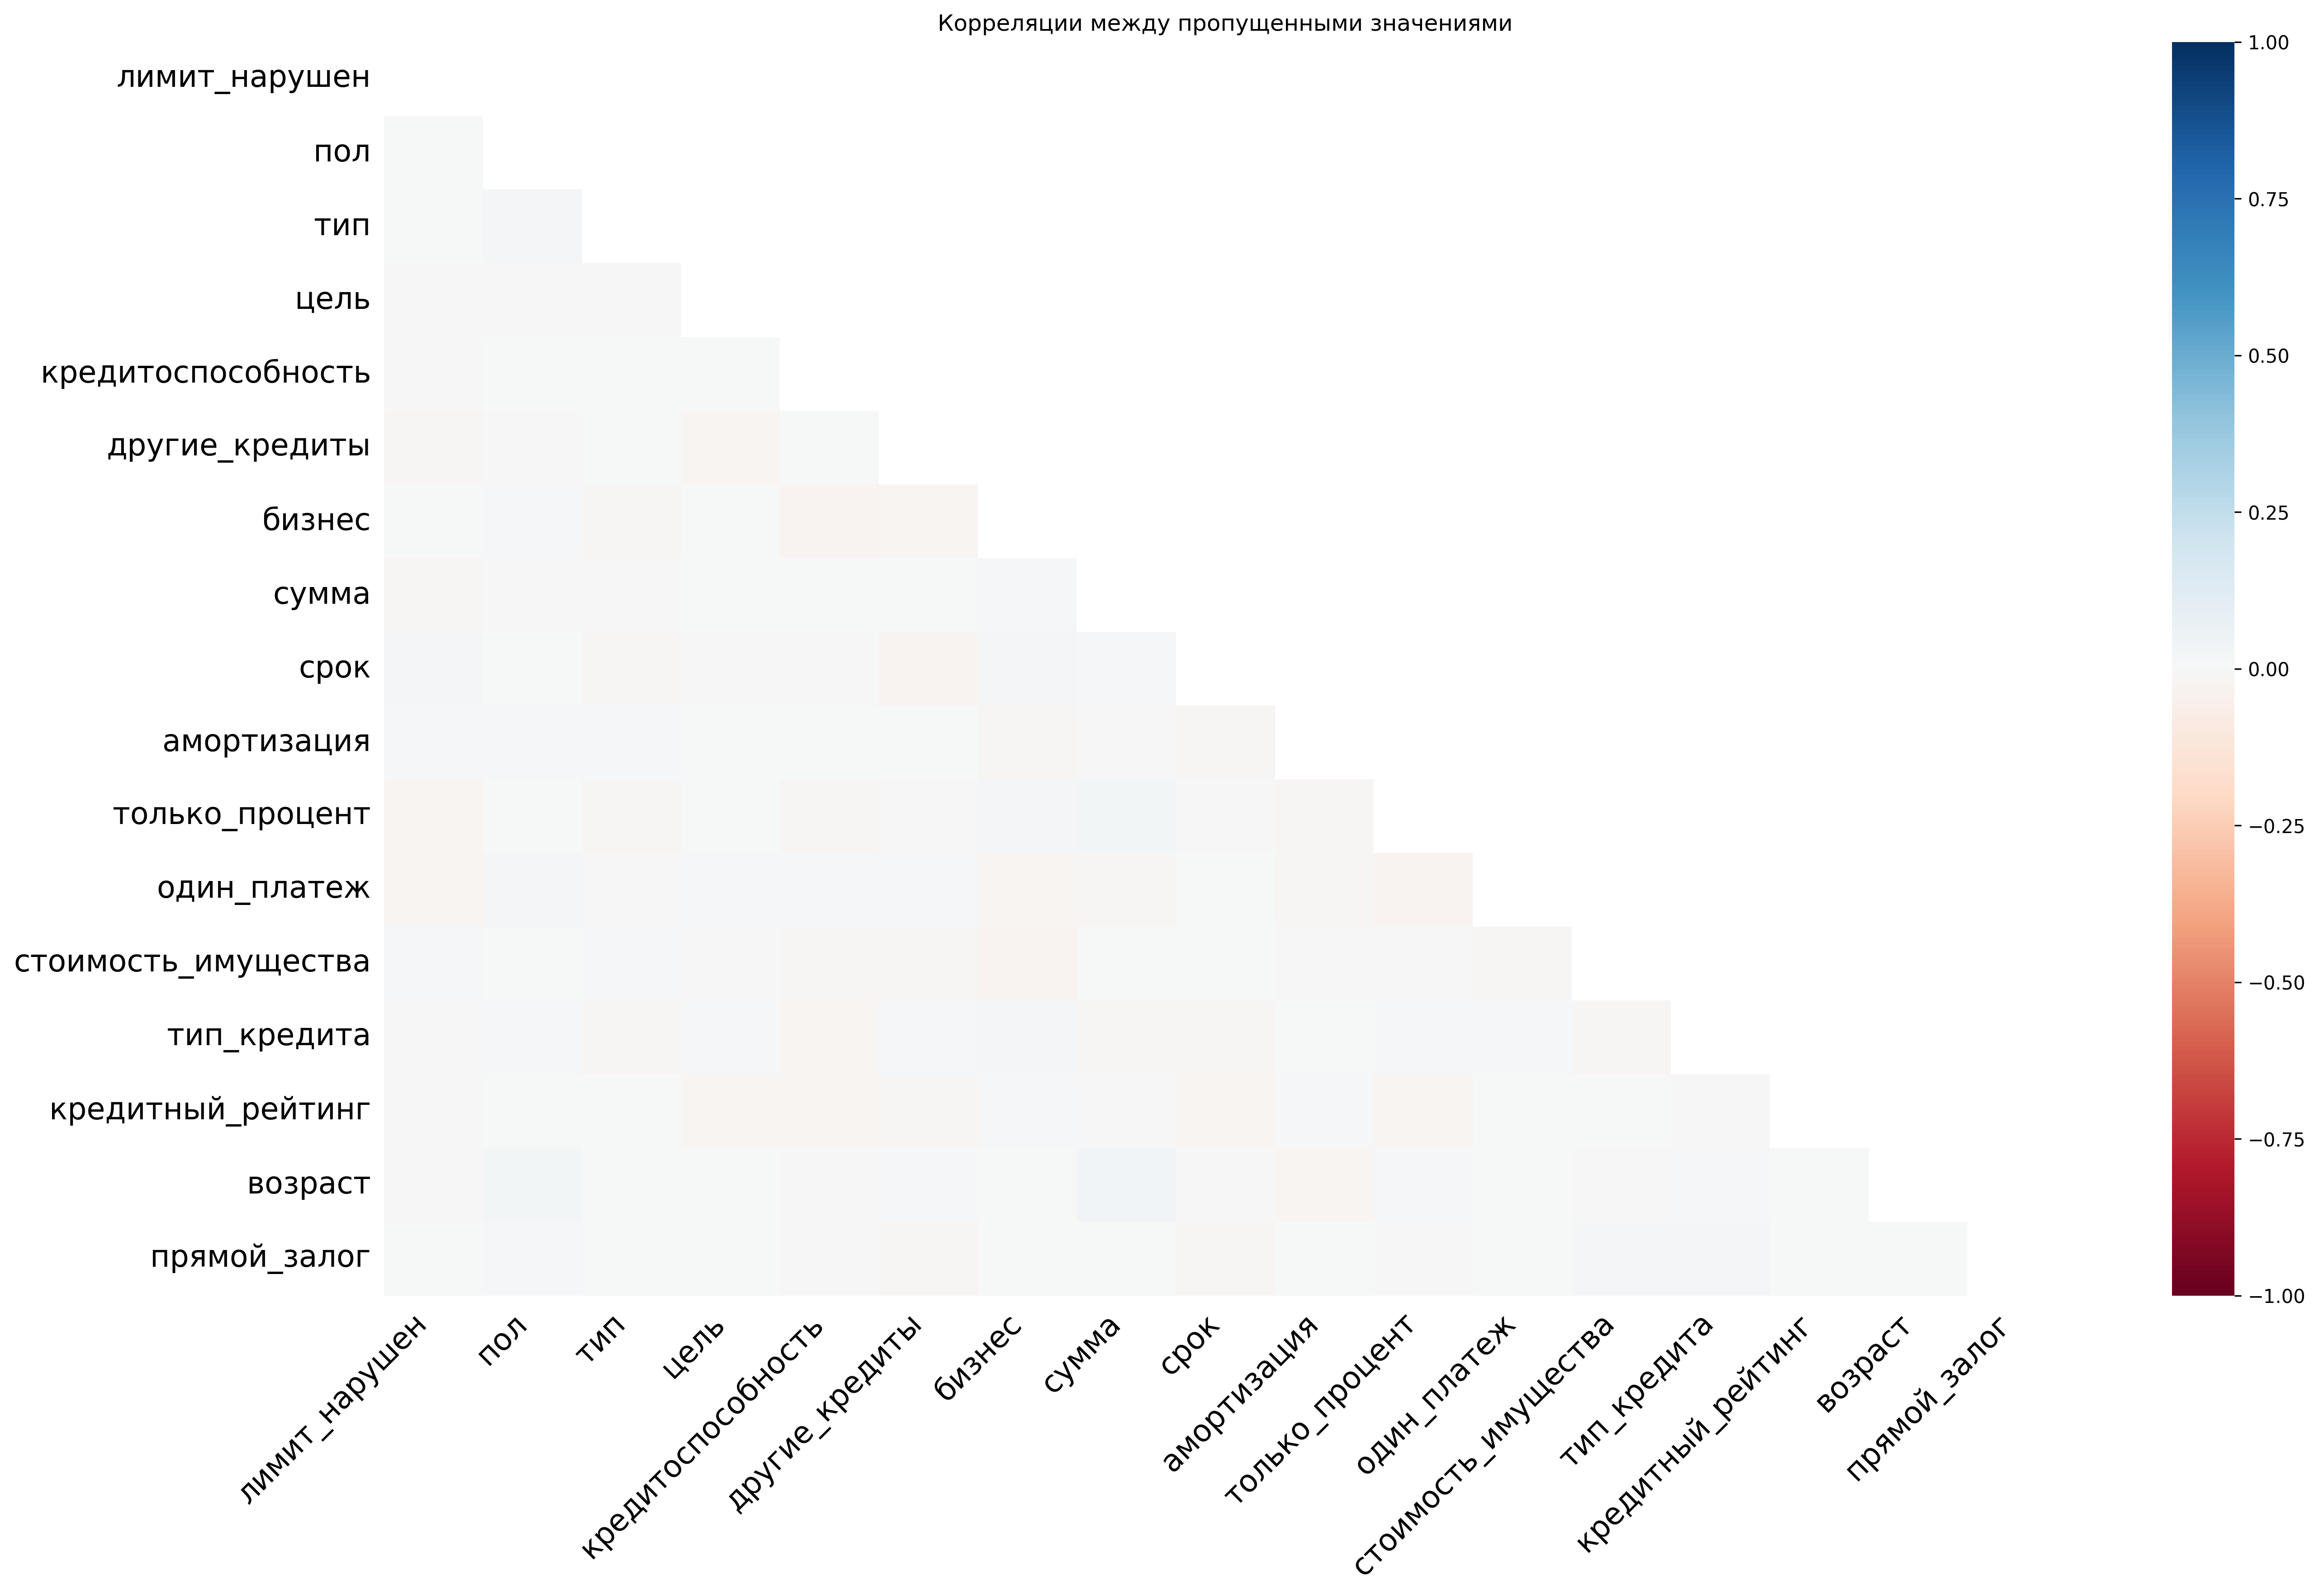

In [16]:
import missingno as msno

msno.matrix(loan_data)
plt.title("Визуализация пропущенных значений")
plt.show()
msno.bar(loan_data)
plt.title("Распределение пропущенных значений")
plt.show()
msno.heatmap(loan_data)
plt.title("Корреляции между пропущенными значениями")
plt.show()


### Датасет: анализ аномалий

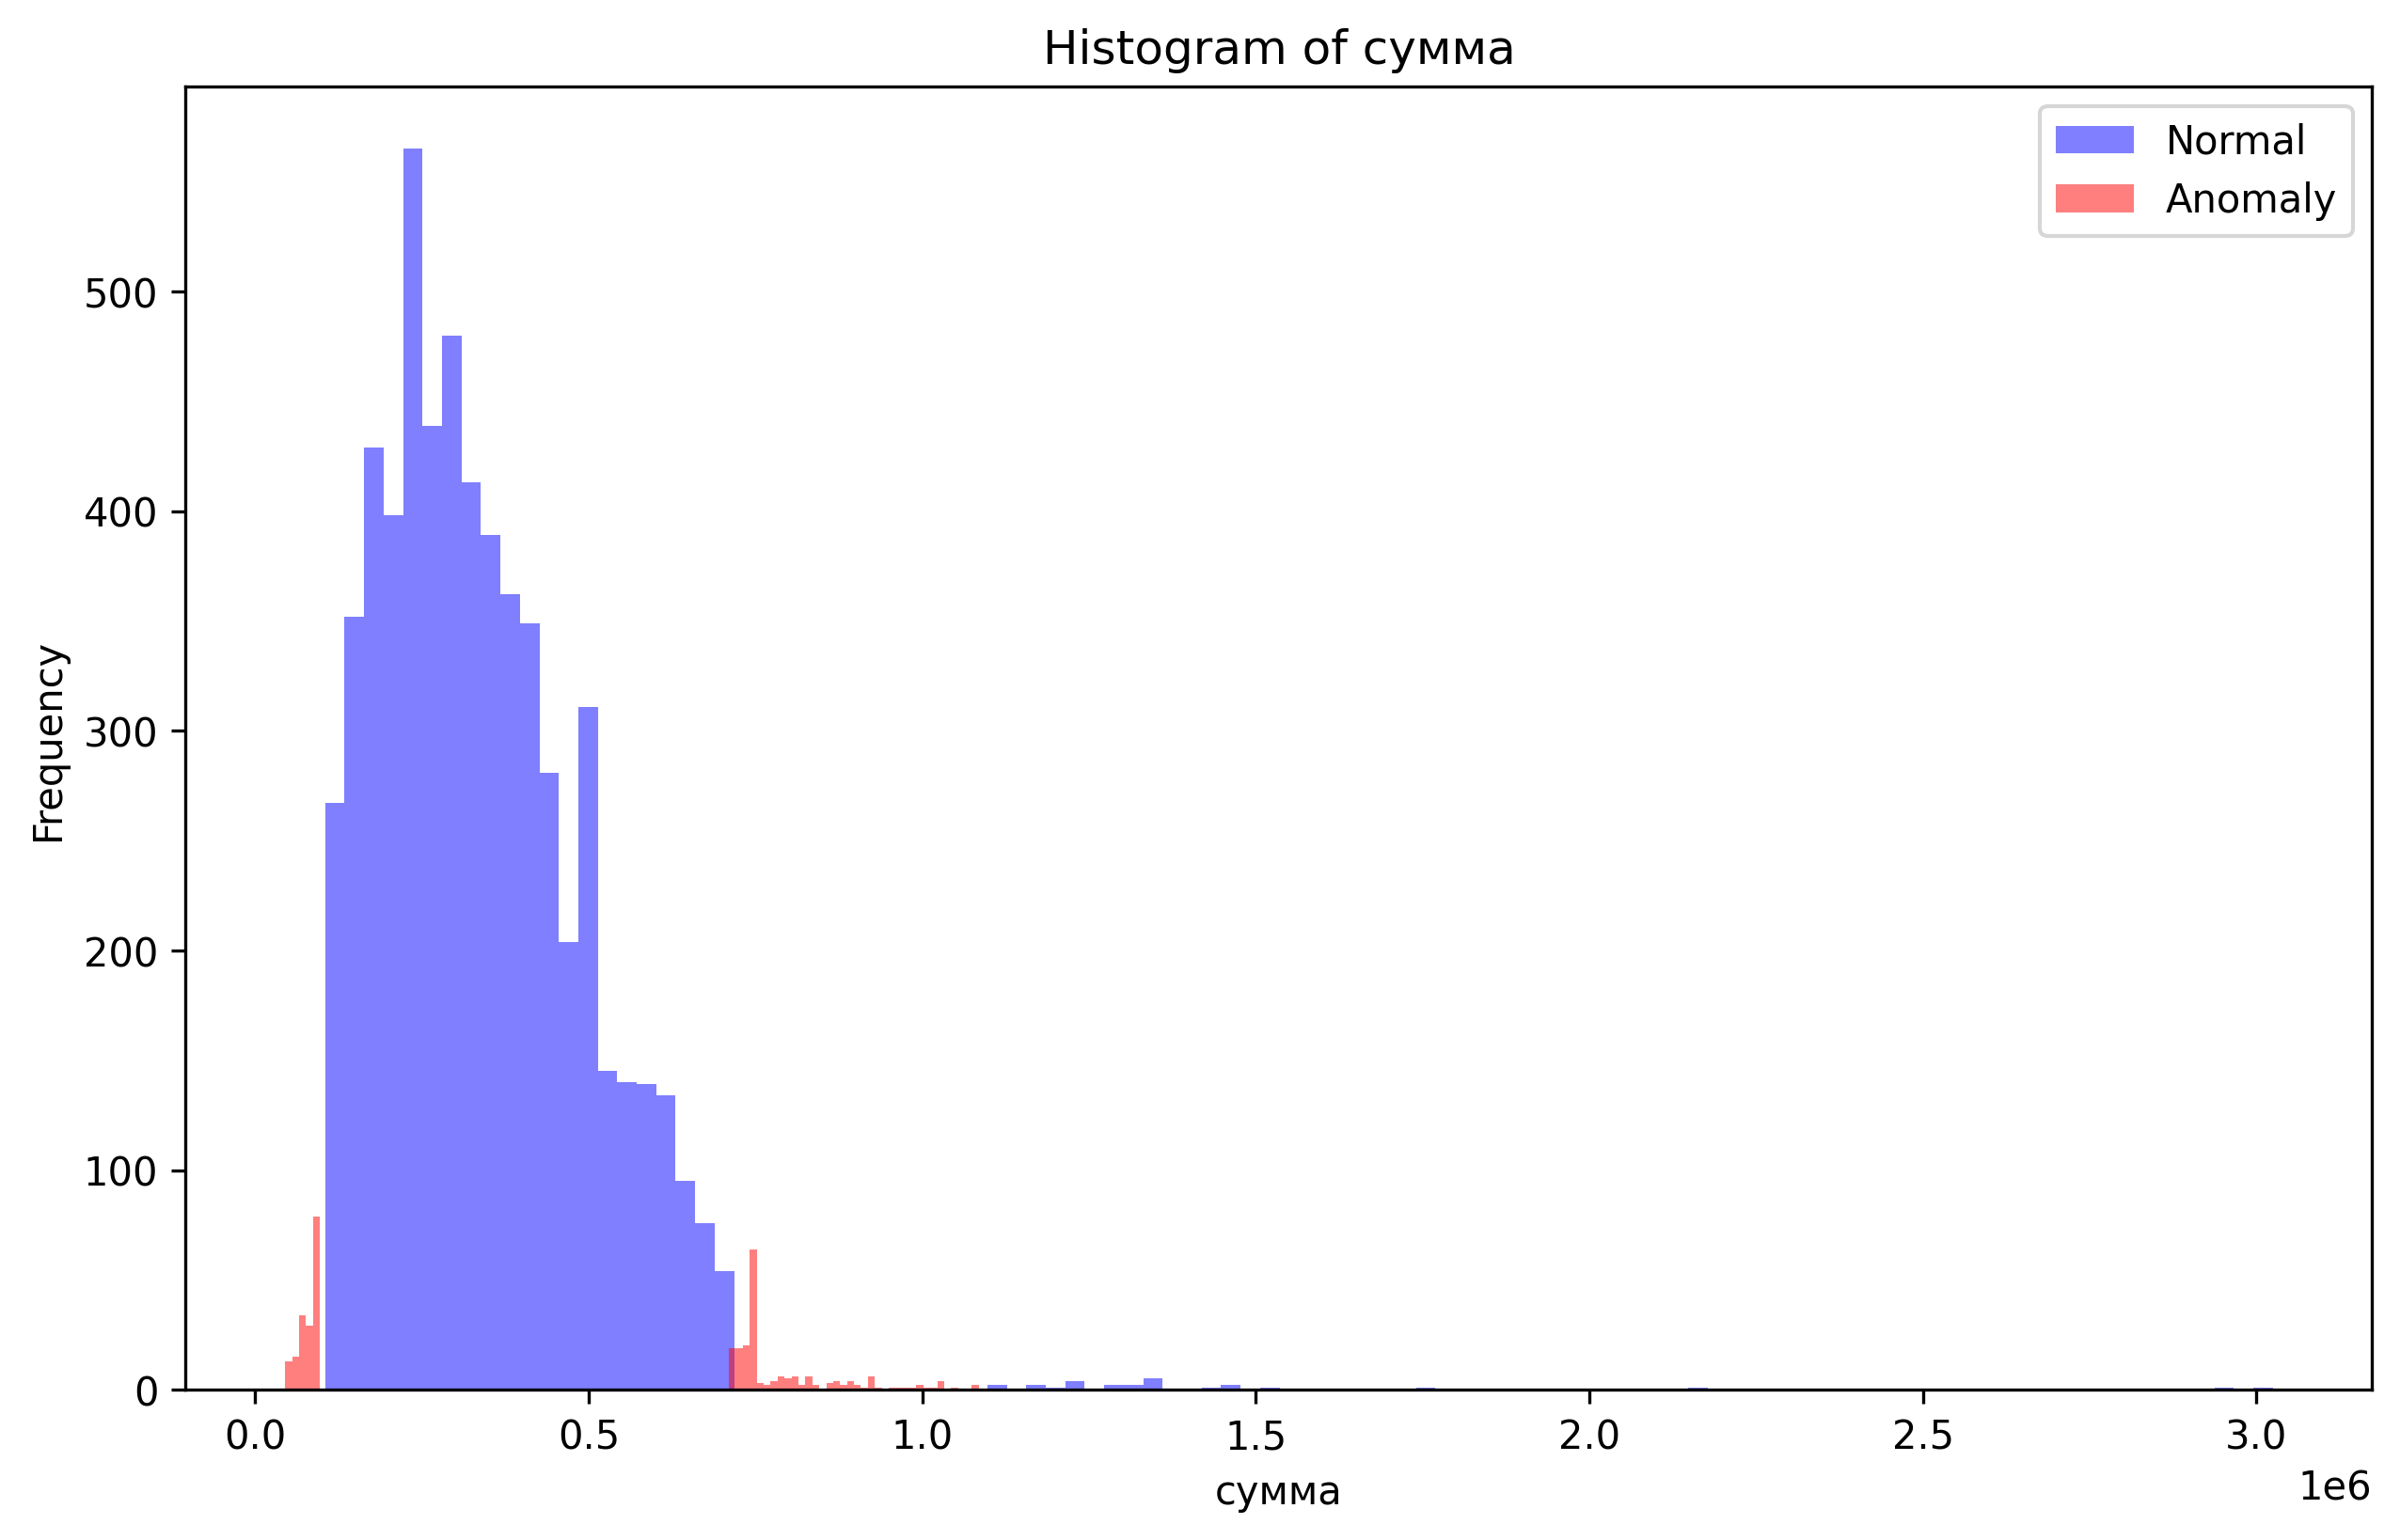

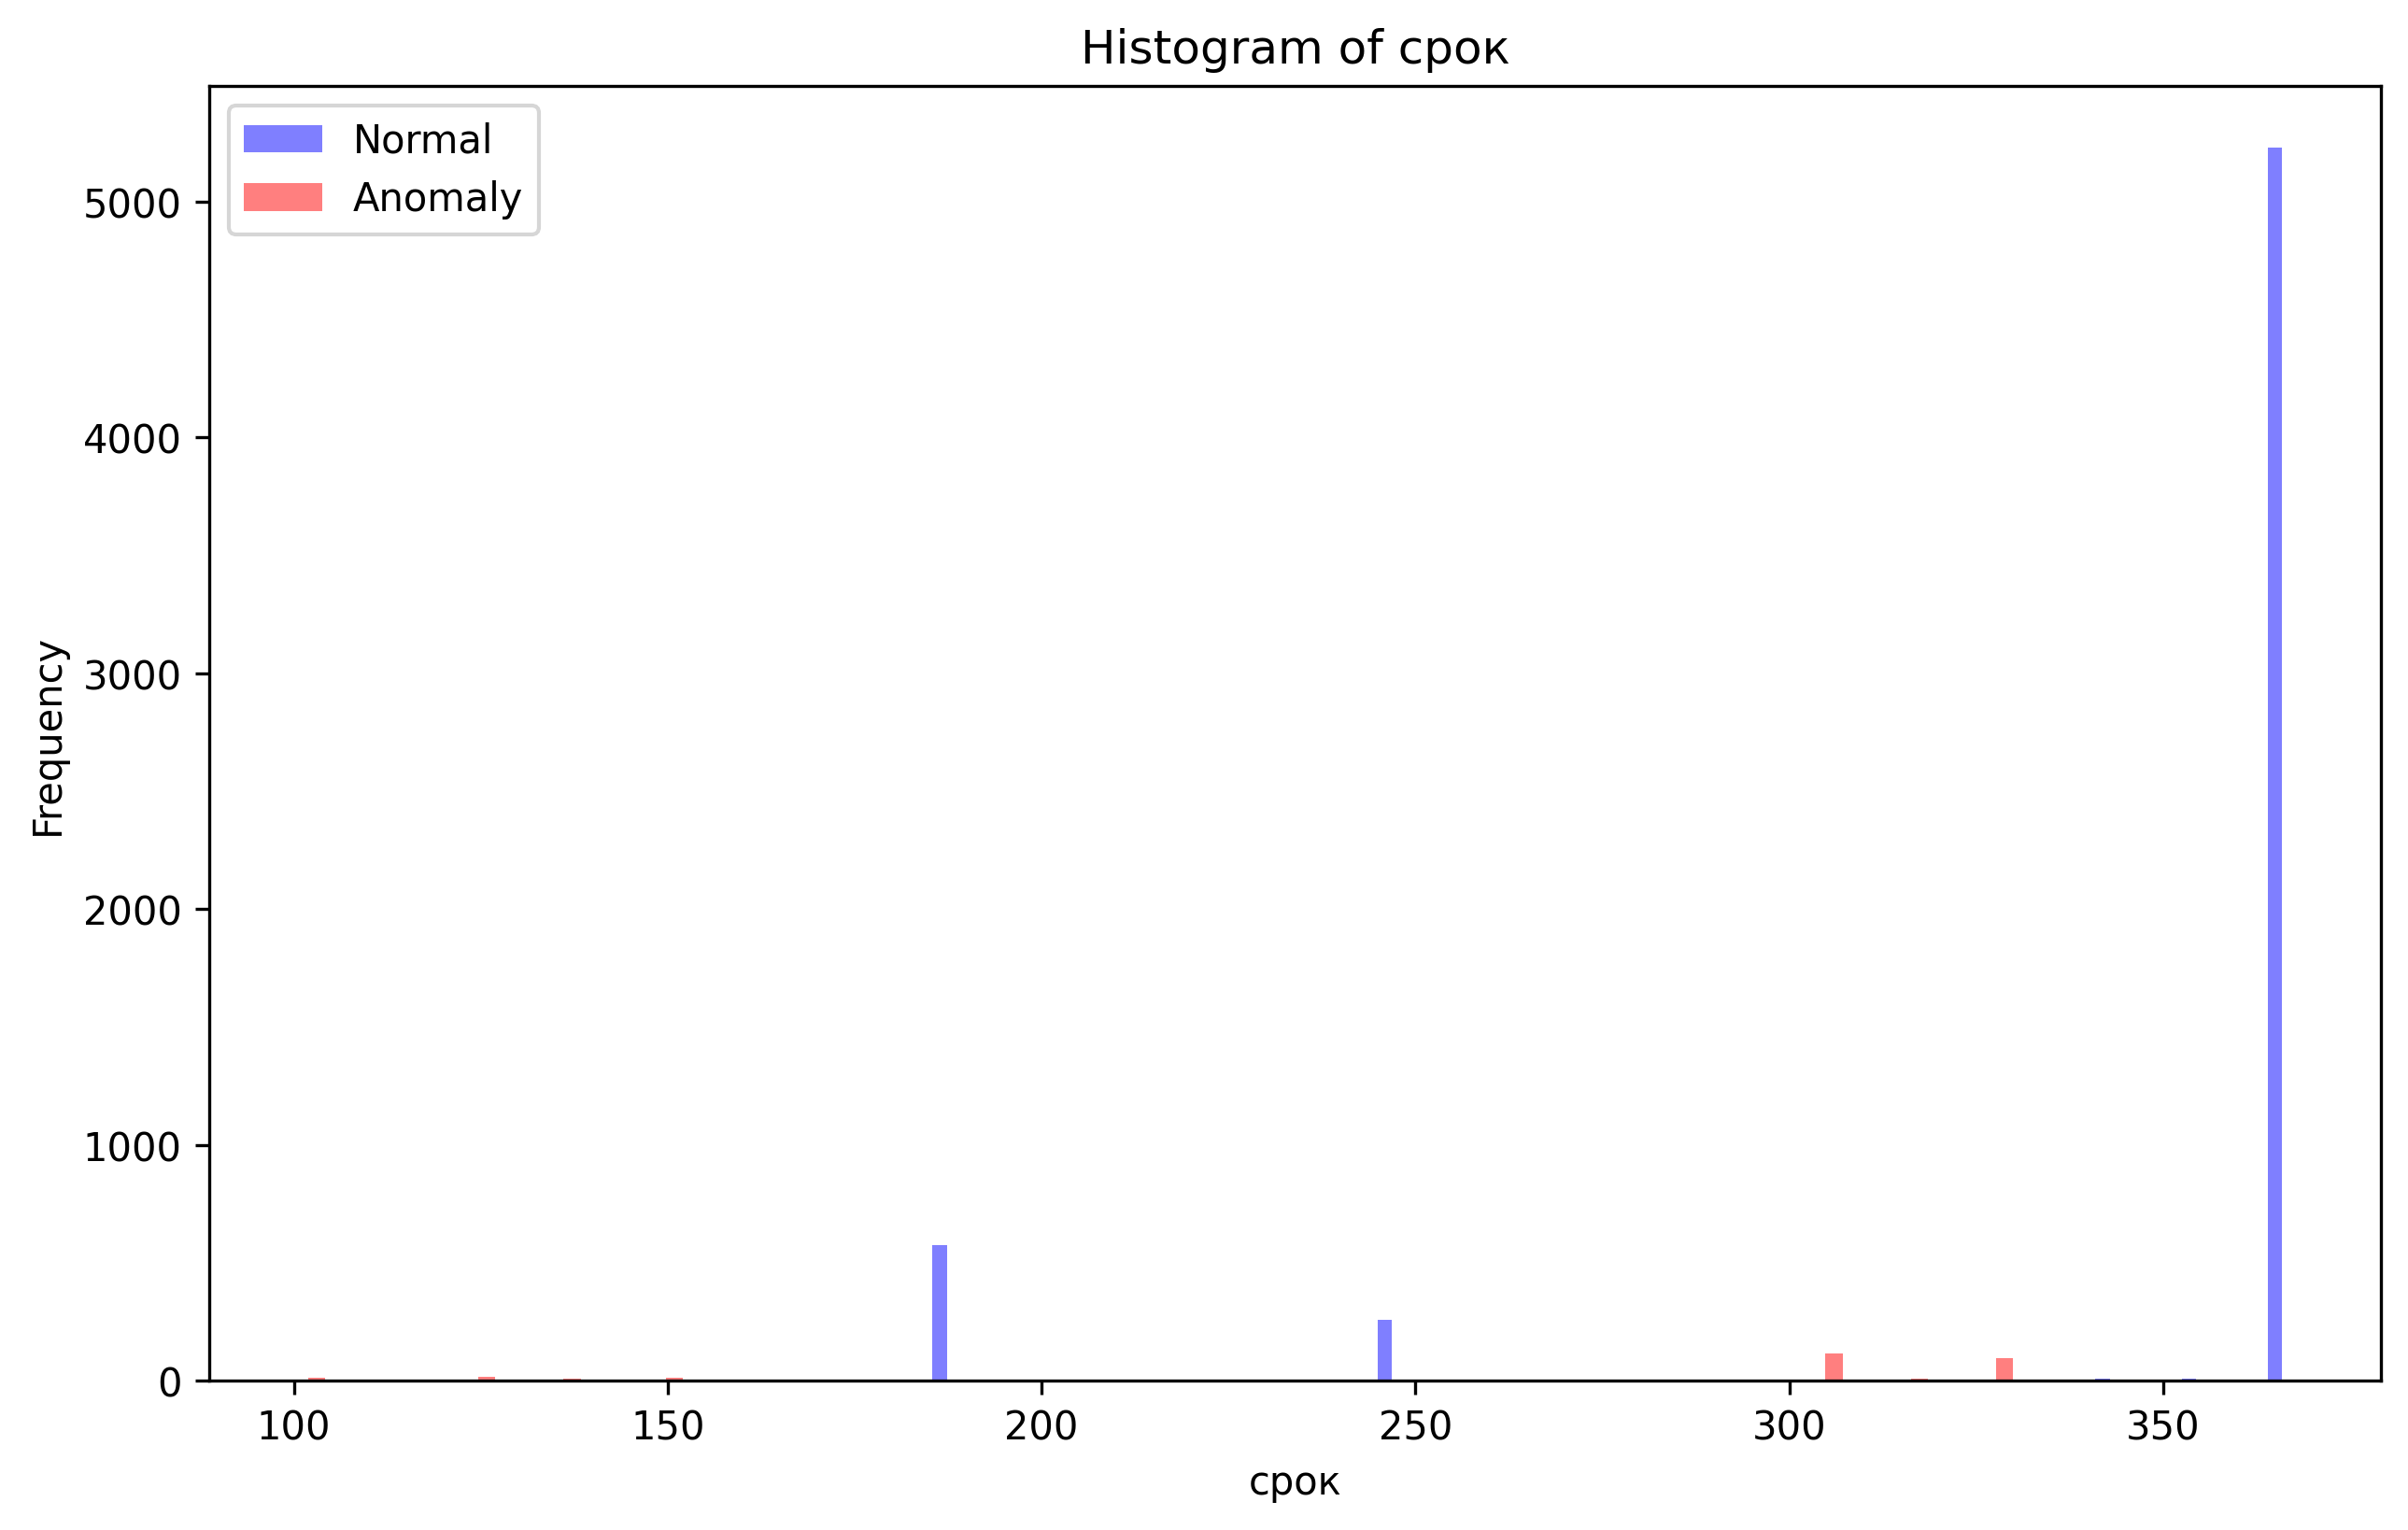

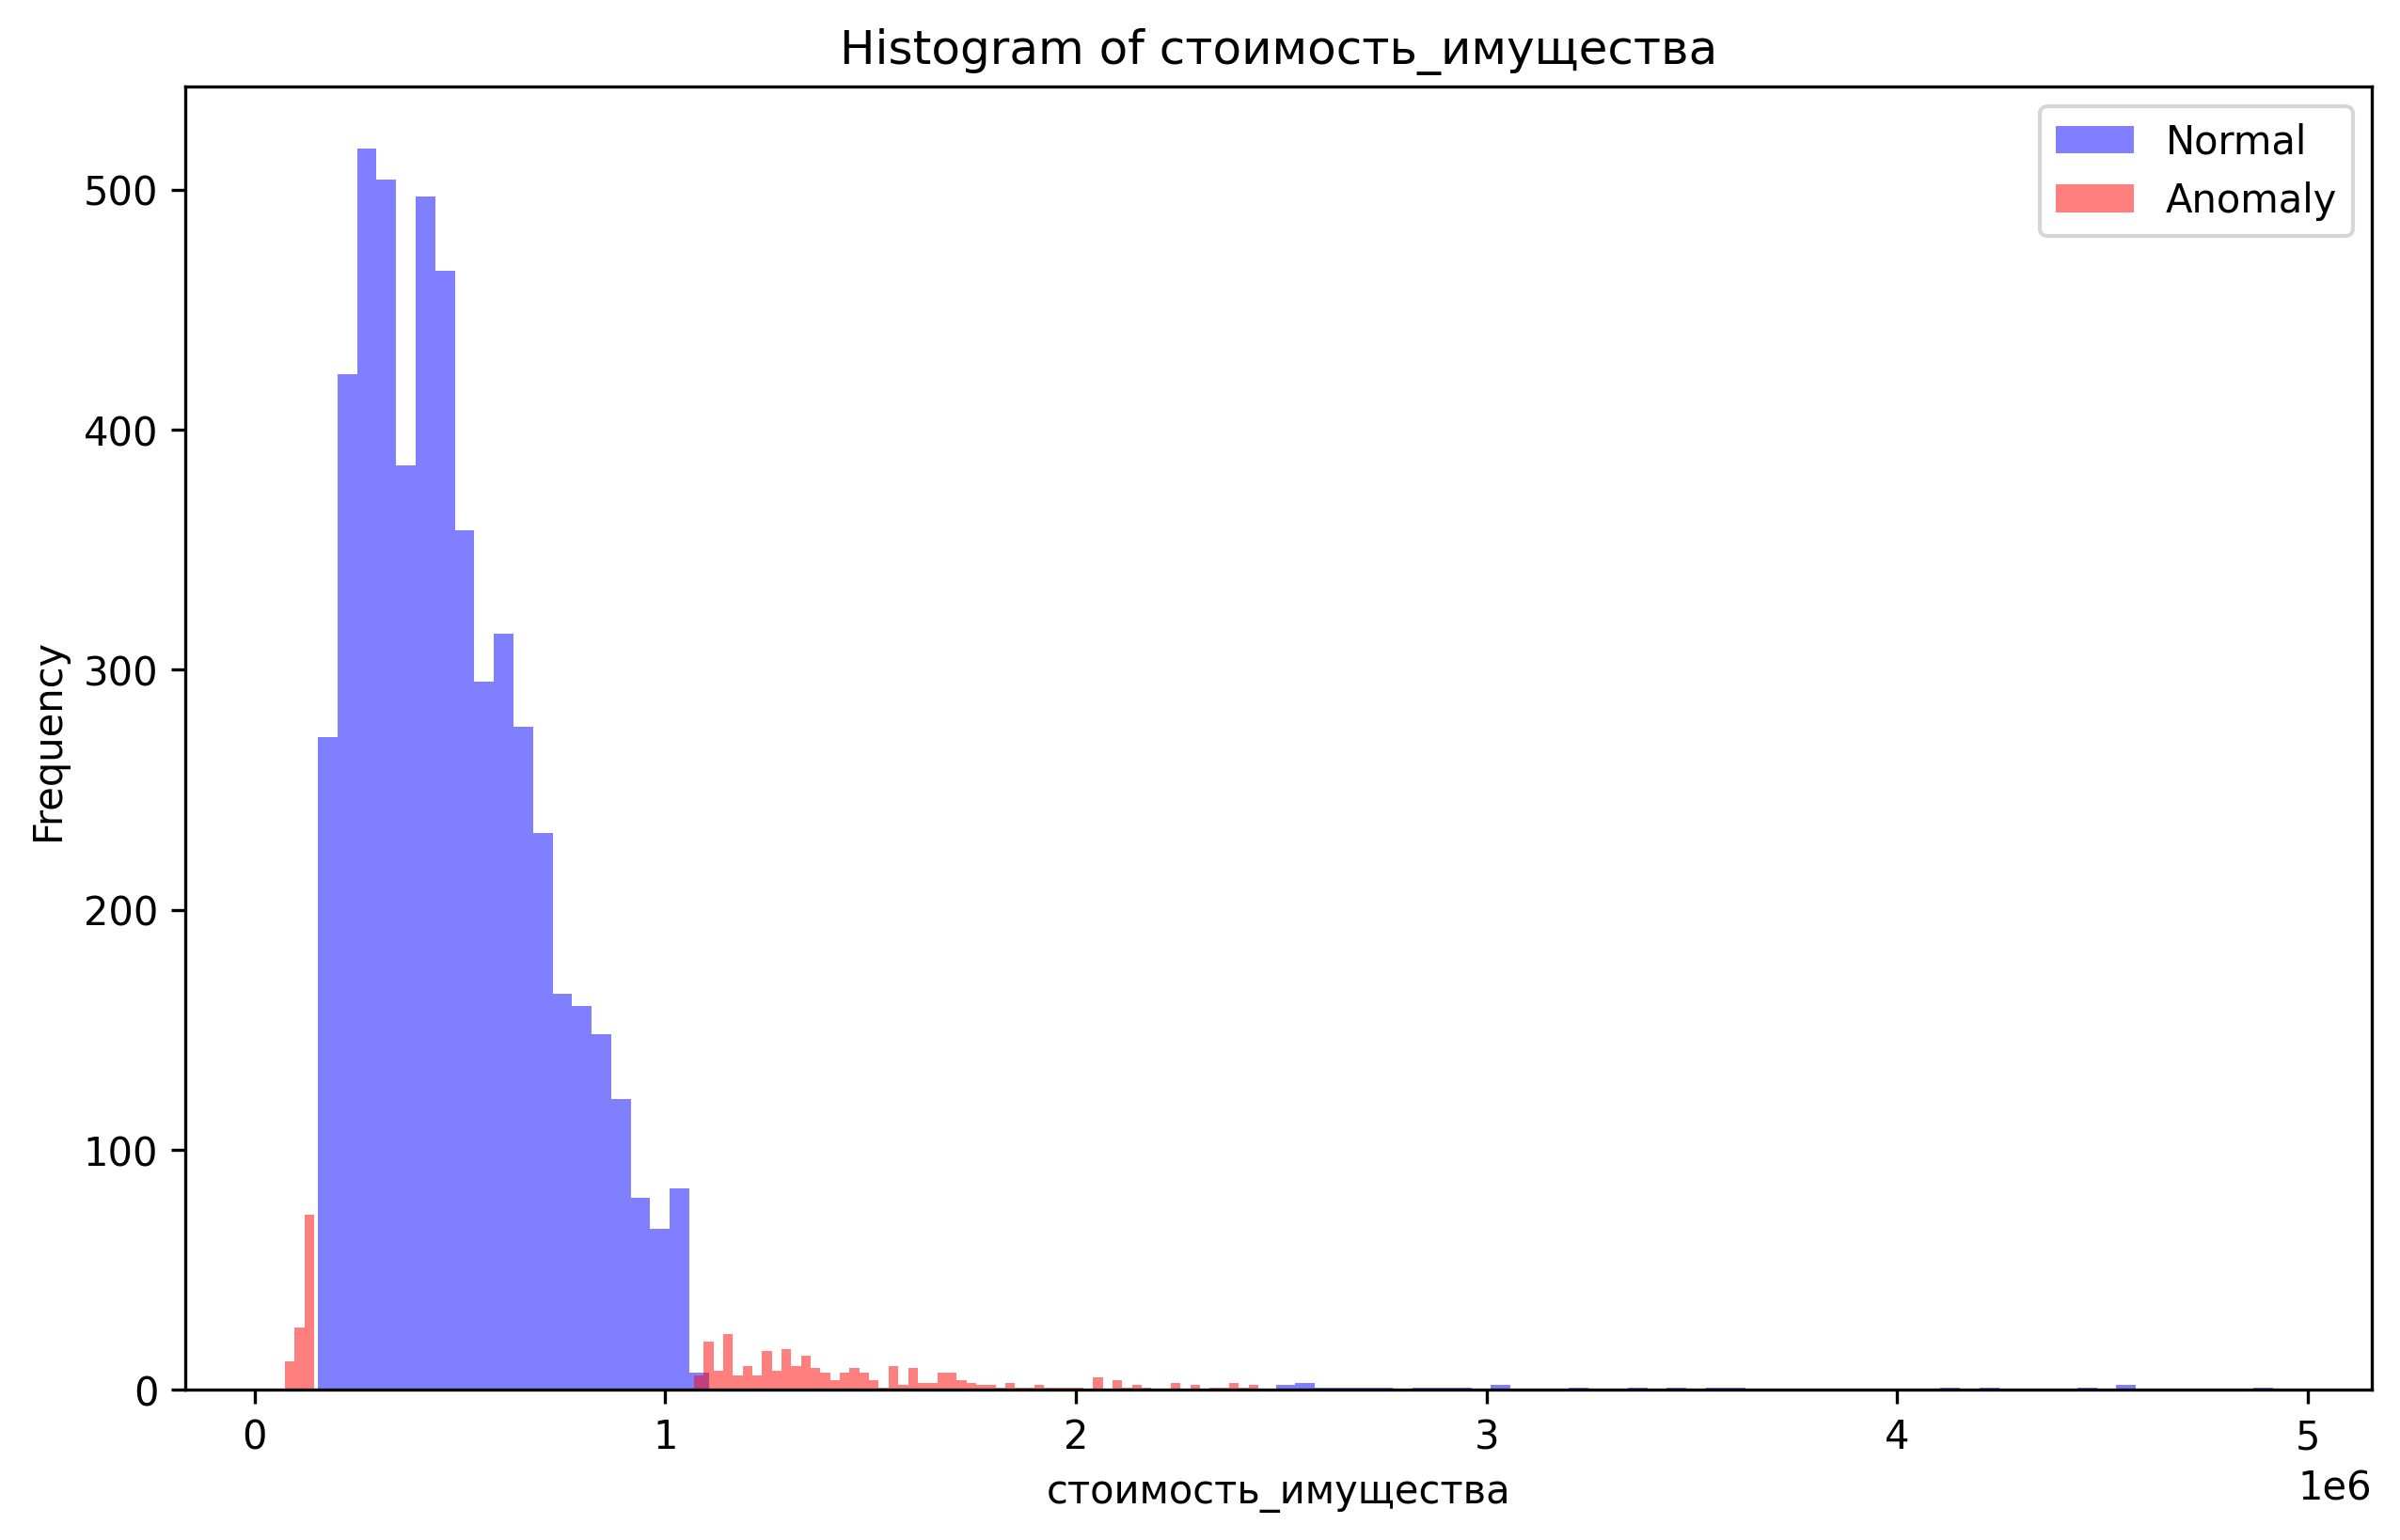

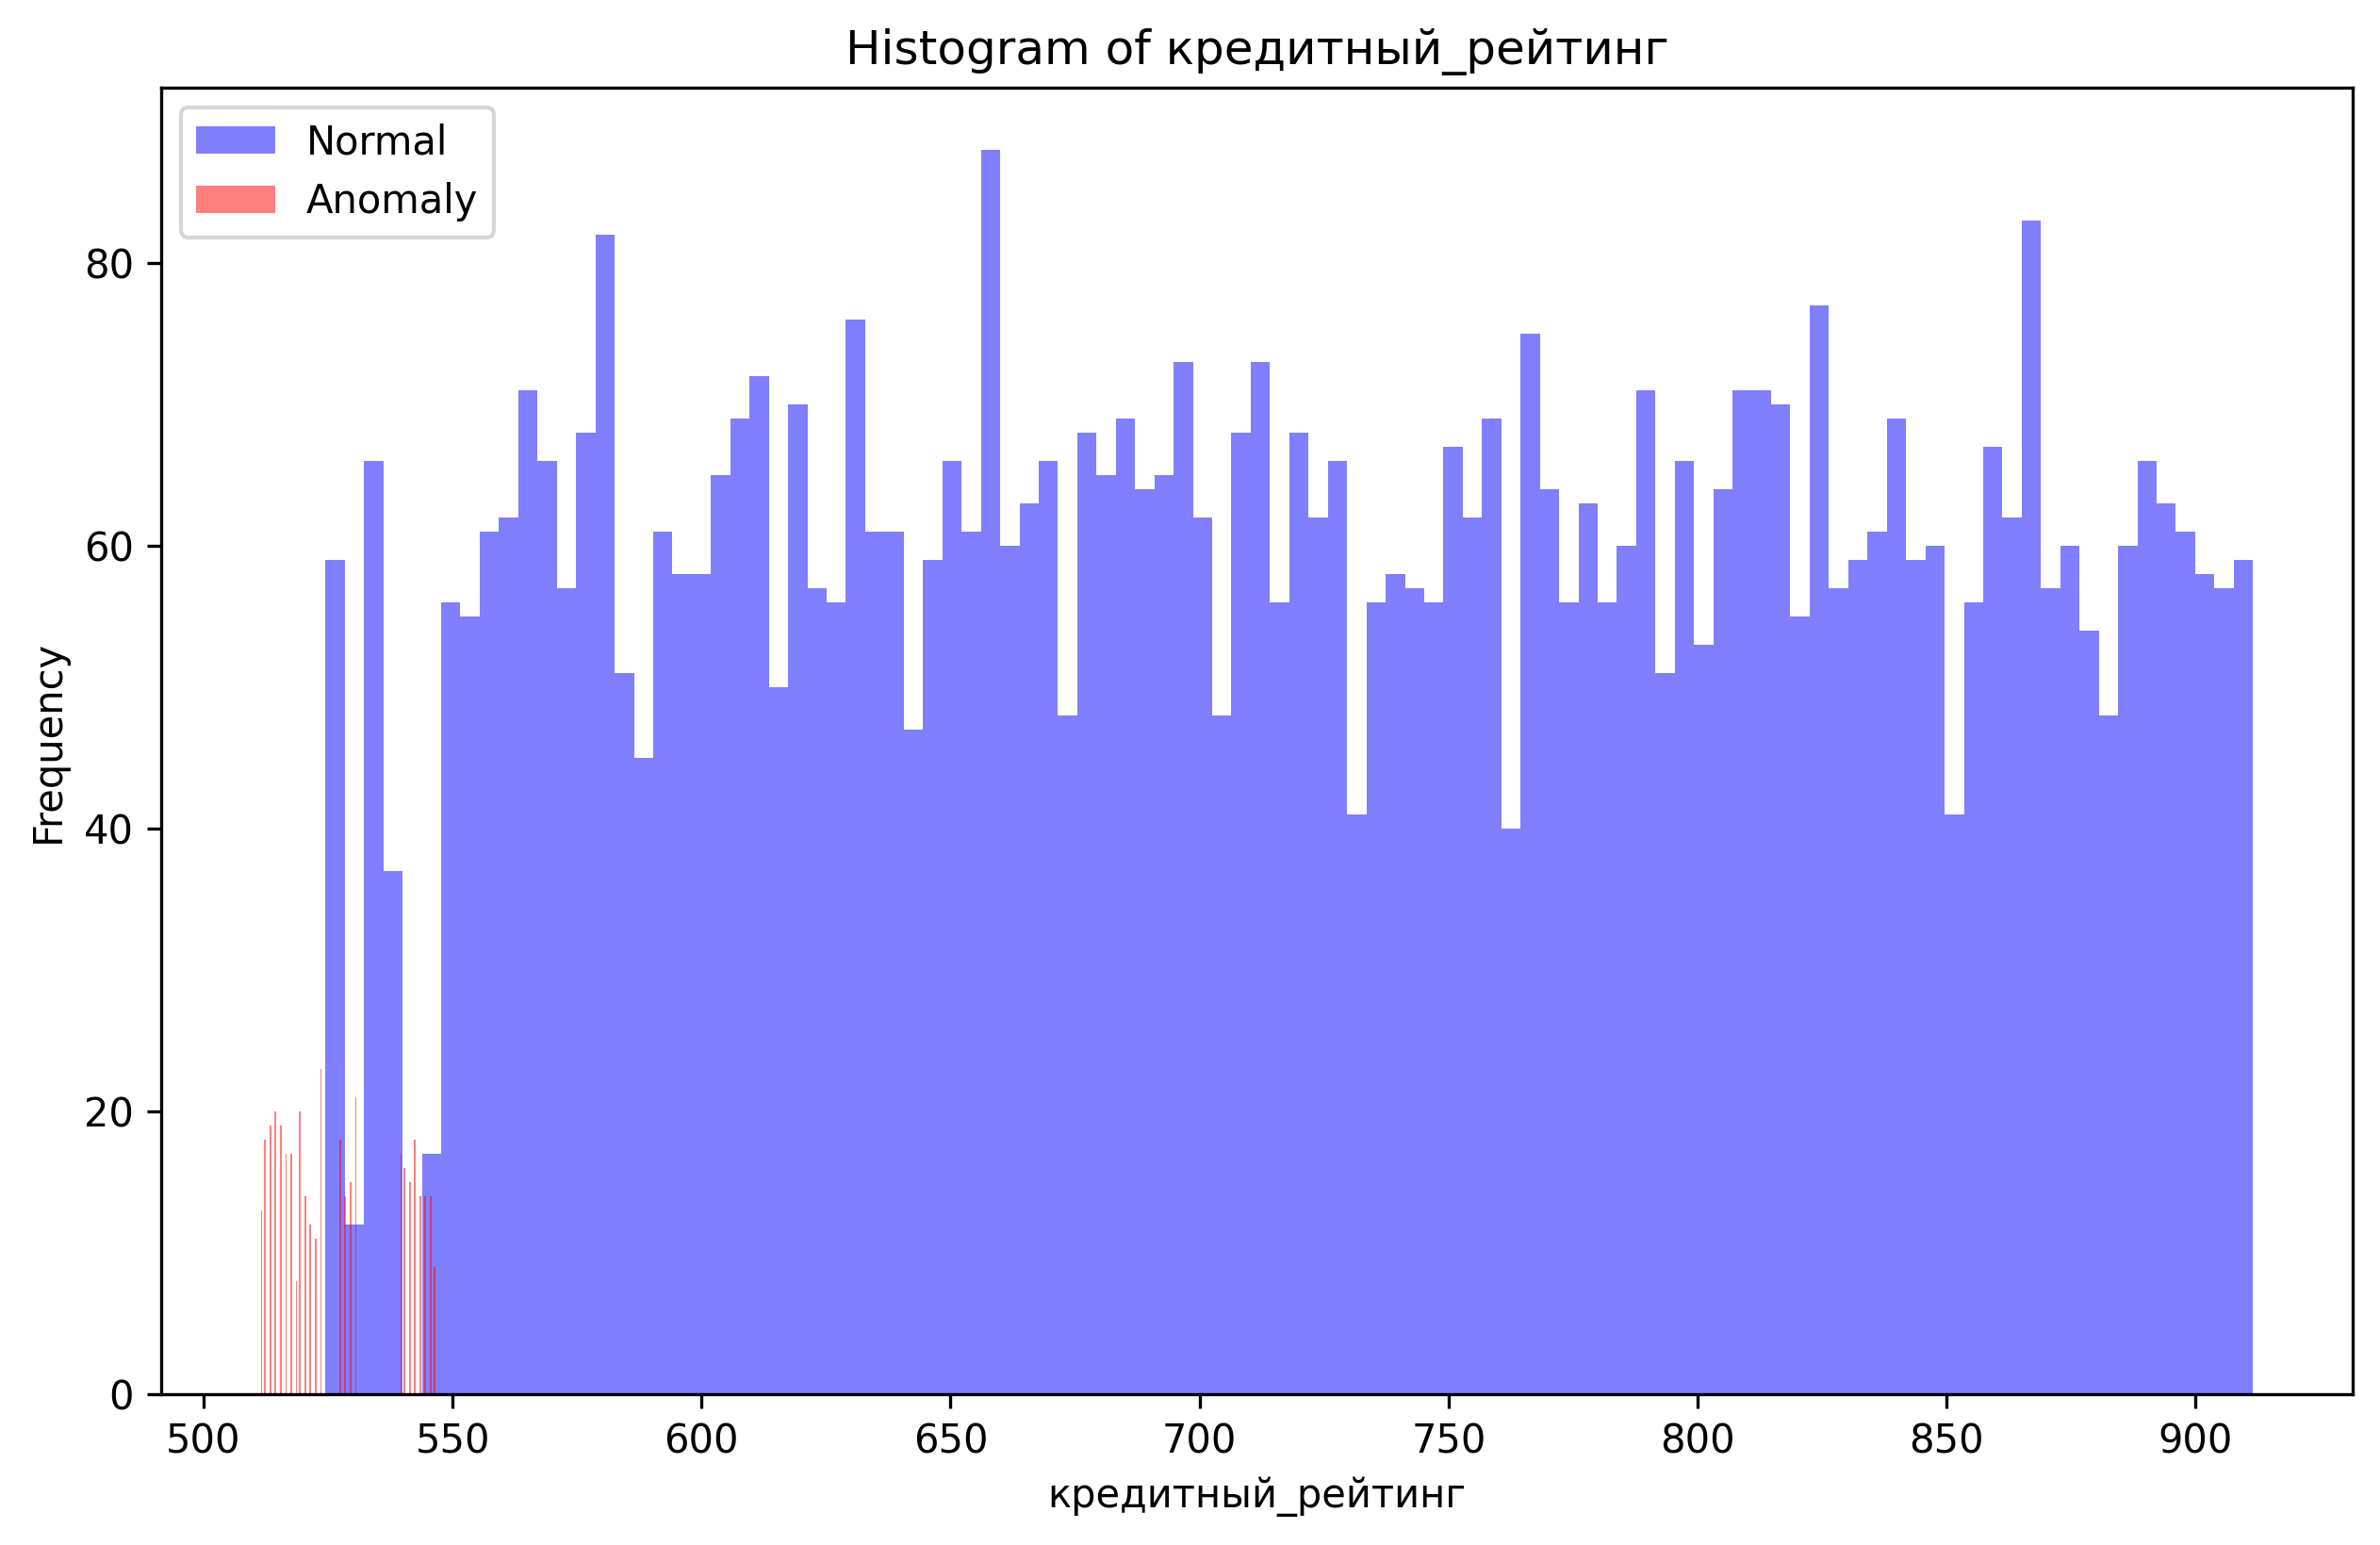

In [13]:
vis.plot_anomalies(loan_data)


### Модель: выделить трейн/тест

In [14]:
df_train, df_test = modeling.get_train_test(loan_data)
df_train.shape, df_test.shape

((5360, 22), (2640, 22))

In [16]:
def train_log_reg_train_test(loan_data: pd.DataFrame) -> None:
    df_train, df_test = modeling.get_train_test(loan_data)

    X_train, y_train = modeling.get_xy(df_train)
    X_test, y_test = modeling.get_xy(df_test)

    num_cols = X_train.select_dtypes(exclude=object).columns

    pipe = Pipeline(
        [
            ("feat_select", modeling.ManualFeatureSelector(num_cols)),
            ("impute", SimpleImputer(strategy="constant", fill_value=0)),
            ("model", LogisticRegression(random_state=42)),
        ]
    )

    pipe.fit(X_train, y_train)

    print("Train")
    pred = pipe.predict(X_train)
    modeling.print_metrics(y_pred=pred, y_true=y_train)
    print()

    print("Test")
    pred = pipe.predict(X_test)
    modeling.print_metrics(y_pred=pred, y_true=y_test)
    print()


train_log_reg_train_test(loan_data)

Train
Log reg
Accuracy: 0.815
f1: 0.426

Test
Log reg
Accuracy: 0.797
f1: 0.410



/Users/user/Main/Repos/hse-ml-managers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Так как я организовал модели в пайплайнах, я могу довольно просто добавлять туда еще элементы предобработки вроде нормализации и обработки пропущенных значений

### Бизнес: какую метрику использовать

Тут я так понимаю студенты сами будут придумывать подходящую метрику

### Моделирование: под кастомную метрику можно перебирать гиперпараметры модели